In [1]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from vpython import *
from math import *
scene = canvas()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
seed(42)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [4]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points
def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

In [2]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [6]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [7]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        orientation: 0, 1, or 2. 0 stands for coronal. 1 stands for transverse. 2 stands for sagittal.
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def ReadPointFromPNG(filepath, orientation:int, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now convert them to point coordinates in 3D")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
    
    
    # Transfrom the matrix to list of points' coordinate whose grey scalse is not 0 (colon area)
    if(orientation == 0):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [1, 2, 0]]
        #xyz[:, 2] = xyz[:, 2]*3*thickness
        
    elif(orientation == 1):
        yxz = np.transpose(np.where(imageData))
        xyz = yxz[:, [1, 0, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
        
    elif(orientation == 2):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [0, 1, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
    
    else:
        print("Orientation shoud only be one of 0, 1 or 2 only.  0 stands for coronal. \
        1 stands for transverse. 2 stands for sagittal.")
        
    print("Done!")
    return xyz

In [8]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# return: a tuple(closestIndices, closesDis). ClosestIndices is a matrix of each point's neighbors. 
#         closestDis is a matrix of the distances between each point and their neighbors

def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10 # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [9]:
# This function converts points' coordinate data into a minimum spanning tree. In this graph, the nodes are the points
# from the points cloud and the edges are the connection between each point and their neighbors. The weights are each 
# connection's distance in space
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# Return: A networkX instance containing the MST

def CreateMSTGraph(pointsData):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData)
    print("---------------")
    print("Nearby points calculation Done!")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [10]:
# Impliment the collect algorithm for 3D points in the paper. This is a recursive function which may not be efficient 
# enough for the project. The non-Recursive version is right below.

def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [11]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [12]:
# Calculate the weight between any tew points. This weight is used to calculate regression plane
# Params: P1: the index of the first point
#         P2: the index of the second point
# Return: the weight between the two points

def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [13]:
# Calculate the regression plane for a specific point given its neighbors. 
# Params: PStar: the index of the point for which we want to find the gression plane.
#         A: A set of points' indicies representing PStar's neighbors
# Return: fitted_params: the regression plane's parameters, which is the A, B, C in Ax + By + C - z = 0

def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    
    # The following code is used for a dynamic programming version. But currently there is no perfermance improvement 
    # using this technique. Need to explore further
    # global curScalar
    # global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c = params 
        loss = sum(((a * xMatrix + b*yMatrix + c - zMatrix)**2)*wM)
        
        # Dynamic programming version
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [14]:
# This function projects a list of points to a plane specified using 'params' and return their coordinate after the
# projection in 3D
# Param: params: a plane's parameters, which is the A, B, C in Ax + By + C - z = 0
#        A: a list of points (points' indices) that need to be projected

def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c = params
    normal = np.asarray([a, b, -1])
    normal = normal / np.linalg.norm(normal)
    pointOnPlane = np.asarray([0, 0, c])
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [15]:
# This function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )

def convertTo2DCor(pointsCor, planeParam):
    a, b, c = planeParam
    origin = np.array([0, 0, c])
    u = np.array([0, 0, c]) - np.array([1, 1, a + b + c])
    u = u / np.linalg.norm(u)
    normal = np.array([a, b, -1])
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [16]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [17]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [18]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [19]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [20]:
# This function is used to reconstruct the end point of the centerline after cleaning

def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    for grandChild in removedNodeDict[child]:
        if(graph_centerline.has_node(grandChild)):
            deleteChild(grandChild)
        

In [21]:
# This function is used to reconstruct the end point of the centerline after cleaning

def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(child, curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(child, curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(parent, child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [22]:
# This function is used for visulize the centerline in VPython

def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [23]:
filePath = "mri_label_2017/*.png"
pointData = ReadPointFromPNG(filePath, 0, 4)
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=False, sampleNumber=5000)

---------------
Begin reading points data from PNG files
There are 116 PNG files, now convert them to point coordinates in 3D
Done!
---------------
There are 4074192 points in total. Now sampleling 5000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


In [24]:
displayPoints(pointsCor3D, 1.3)

In [25]:
# the code to move points toward the centerline 
points_centerline = []

# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 30
    H_delta = 3
    H_glo = 0
    trial_limit = 20
    min_neighbors = 150
    max_neighbors = 750
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points that has been moved
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    results = []
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(2000, 3000):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1]
        # The next two lines are used in a dynamic programming version of computing the centerline
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
            
            #curPlaneGuess = [1, 1, 1]
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)
            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        pointsCor3D[targetPoint] = list(newCor3D)
        dirty_dict[targetPoint] = 1
        results.append(max(correlation_hist))
        points_centerline.append(newCor3D)
        
    displayPoints(points_centerline, 0.5)    

2000 trial 0 H = 44 : 0.1391961026799345 size: 233
2000 trial 1 H = 47 : 0.18011757935047729 size: 247
2000 trial 2 H = 50 : 0.25622177550305114 size: 276
[183 406 256] [178.43610517 403.54790632 261.58423871]
2001 trial 0 H = 53 : 0.030977689098899707 size: 166
2001 trial 1 H = 56 : 0.09648227788364817 size: 178
2001 trial 2 H = 59 : 0.06684057398400434 size: 185
2001 trial 3 H = 62 : 0.07486542589142244 size: 196
2001 trial 4 H = 65 : 0.049829895826568306 size: 219
2001 trial 5 H = 68 : 0.02562704949783378 size: 264
2001 trial 6 H = 71 : 0.5217966536239954 size: 305
[116 313 111] [134.68987656 322.1533781  132.59559701]
2002 trial 0 H = 41 : 0.022040018254784223 size: 164
2002 trial 1 H = 44 : 0.02631826593067301 size: 187
2002 trial 2 H = 47 : 0.09626307331922546 size: 232
2002 trial 3 H = 50 : 0.07335859019072329 size: 253
2002 trial 4 H = 53 : 0.1592730639916981 size: 278
2002 trial 5 H = 56 : 0.30747033784139394 size: 311
[228 150  97] [219.55525885 145.5188006  107.24794151]
200

2028 trial 5 H = 65 : 0.04657840860393717 size: 360
2028 trial 6 H = 68 : 0.0059356557835481645 size: 394
2028 trial 7 H = 71 : 0.08672884240270666 size: 436
2028 trial 8 H = 74 : 0.03157325066766684 size: 486
2028 trial 9 H = 77 : 0.002736746057196122 size: 505
2028 trial 10 H = 80 : 0.01767812271207968 size: 513
2028 trial 11 H = 83 : 0.0565084200058226 size: 531
2028 trial 12 H = 86 : 0.18695198864022072 size: 761
[135 405 146] [141.35529975 403.79380756 158.41992306]
2029 trial 0 H = 59 : 0.4211679441779679 size: 249
[247  43 179] [260.2585935   55.49787775 164.9831317 ]
2030 trial 0 H = 44 : 0.08458361862800941 size: 153
2030 trial 1 H = 47 : 0.09903133371840328 size: 170
2030 trial 2 H = 50 : 0.046372725737773915 size: 188
2030 trial 3 H = 53 : 0.11654431064176975 size: 249
2030 trial 4 H = 56 : 0.2737419768830104 size: 389
[301 116 202] [298.78032245 110.1395152  214.49873399]
2031 trial 0 H = 56 : 0.1618527871808779 size: 321
2031 trial 1 H = 59 : 0.034421472076151156 size: 384

2057 trial 0 H = 44 : 0.10187009265658412 size: 179
2057 trial 1 H = 47 : 0.0284171427488416 size: 235
2057 trial 2 H = 50 : 0.09438125124876988 size: 269
2057 trial 3 H = 53 : 0.12433749459311177 size: 289
2057 trial 4 H = 56 : 0.11872788152157791 size: 298
2057 trial 5 H = 59 : 0.09624432187887144 size: 417
2057 trial 6 H = 62 : 0.07349223121174898 size: 466
2057 trial 7 H = 65 : 0.04929907248160132 size: 490
2057 trial 8 H = 68 : 0.05087869165346806 size: 510
2057 trial 9 H = 71 : 0.026999703434942193 size: 541
2057 trial 10 H = 74 : 0.027252427508693524 size: 549
2057 trial 11 H = 77 : 0.01224861858583166 size: 571
2057 trial 12 H = 80 : 0.07646646503909482 size: 737
2057 trial 13 H = 83 : 0.002430588103458521 size: 766
[275 141 234] [270.40429481 142.48709626 245.33213696]
2058 trial 0 H = 53 : 0.03783690437618371 size: 179
2058 trial 1 H = 56 : 0.12859694670527308 size: 229
2058 trial 2 H = 59 : 0.10055110218574043 size: 244
2058 trial 3 H = 62 : 0.18638511020649698 size: 265
205

2084 trial 4 H = 50 : 0.06346538900689225 size: 218
2084 trial 5 H = 53 : 0.10194308722966121 size: 238
2084 trial 6 H = 56 : 0.08623815830225151 size: 292
2084 trial 7 H = 59 : 0.059860713635538756 size: 309
2084 trial 8 H = 62 : 0.07324679202336674 size: 384
2084 trial 9 H = 65 : 0.16711159911640153 size: 435
2084 trial 10 H = 68 : 0.16292073168403212 size: 454
2084 trial 11 H = 71 : 0.005619899252995417 size: 563
2084 trial 12 H = 74 : 0.020693205323446397 size: 590
2084 trial 13 H = 77 : 0.3462784003179512 size: 715
[294 109 254] [295.3942739  120.93101717 239.67889089]
2085 trial 0 H = 44 : 0.08194066854454078 size: 152
2085 trial 1 H = 47 : 0.12590445644028223 size: 164
2085 trial 2 H = 50 : 0.11909768293620489 size: 175
2085 trial 3 H = 53 : 0.08750808900477944 size: 180
2085 trial 4 H = 56 : 0.25437611263830656 size: 208
[304 416 231] [299.89340154 411.74981025 231.08730208]
2086 trial 0 H = 41 : 0.08120186847366813 size: 150
2086 trial 1 H = 44 : 0.06605821894127198 size: 161


2119 trial 3 H = 59 : 0.08049207659161821 size: 221
2119 trial 4 H = 62 : 0.03891207728012402 size: 232
2119 trial 5 H = 65 : 0.021777742199253866 size: 242
2119 trial 6 H = 68 : 0.01823237501309055 size: 247
2119 trial 7 H = 71 : 0.005759053153783469 size: 269
2119 trial 8 H = 74 : 0.07393444428490412 size: 326
2119 trial 9 H = 77 : 0.00259691240128344 size: 350
2119 trial 10 H = 80 : 0.03424518938501543 size: 361
2119 trial 11 H = 83 : 0.051040047947738955 size: 421
2119 trial 12 H = 86 : 0.12849849030815574 size: 447
2119 trial 13 H = 89 : 0.221791790153163 size: 467
[263  94  85] [257.98295405  91.82621153 110.5185226 ]
2120 trial 0 H = 68 : 0.041085038345225464 size: 153
2120 trial 1 H = 71 : 0.06901654751852639 size: 160
2120 trial 2 H = 74 : 0.14739493482248014 size: 172
2120 trial 3 H = 77 : 0.22565899614340293 size: 440
[127 344  93] [136.55349049 340.541556   124.45470898]
2121 trial 0 H = 41 : 0.38250985761865625 size: 159
[195 442 265] [192.36759754 437.9492954  270.061747 

2151 trial 0 H = 86 : 0.4015922837490429 size: 163
[226 445 337] [211.81151412 424.05803186 320.29795121]
2152 trial 0 H = 38 : 0.029183167401302654 size: 165
2152 trial 1 H = 41 : 0.06360923439353938 size: 205
2152 trial 2 H = 44 : 0.001879433828053455 size: 233
2152 trial 3 H = 47 : 0.015807070407164482 size: 257
2152 trial 4 H = 50 : 0.01617776161801941 size: 272
2152 trial 5 H = 53 : 0.12464692833294425 size: 298
2152 trial 6 H = 56 : 0.28094706250935375 size: 322
[145 311 132] [145.35663175 311.14959649 133.06051178]
2153 trial 0 H = 47 : 0.6057557321439254 size: 162
[280 409 204] [289.58341104 419.09664221 212.75851896]
2154 trial 0 H = 62 : 0.4089303167288453 size: 257
[259  46 136] [262.86754788  58.55274738 155.07295011]
2155 trial 0 H = 38 : 0.16721778728639278 size: 151
2155 trial 1 H = 41 : 0.18160768734580252 size: 167
2155 trial 2 H = 44 : 0.021837457955183086 size: 184
2155 trial 3 H = 47 : 0.07320205824075039 size: 241
2155 trial 4 H = 50 : 0.09163231572112476 size: 272

2171 trial 9 H = 80 : 0.20088329810670955 size: 368
[135 396 247] [154.79355565 406.48704171 244.07751915]
2172 trial 0 H = 41 : 0.0019444117578780022 size: 154
2172 trial 1 H = 44 : 0.028089652546251415 size: 177
2172 trial 2 H = 47 : 0.11913002465409442 size: 236
2172 trial 3 H = 50 : 0.10795568542218191 size: 270
2172 trial 4 H = 53 : 0.19717591234030388 size: 316
2172 trial 5 H = 56 : 0.10116044860090963 size: 359
2172 trial 6 H = 59 : 0.10060039158367257 size: 380
2172 trial 7 H = 62 : 0.12995129519902746 size: 427
2172 trial 8 H = 65 : 0.13520114389952764 size: 453
2172 trial 9 H = 68 : 0.1453271444527557 size: 472
2172 trial 10 H = 71 : 0.1697857928992856 size: 546
2172 trial 11 H = 74 : 0.21048076517829536 size: 571
[205 223 130] [208.90461613 228.89482688 120.08125102]
2173 trial 0 H = 50 : 0.11874791627743016 size: 151
2173 trial 1 H = 53 : 0.13486538593274427 size: 156
2173 trial 2 H = 56 : 0.39008549086542443 size: 200
[263 424 197] [271.43340857 433.3793629  210.50202166]


2203 trial 5 H = 62 : 0.23105513227418198 size: 343
[185 293 112] [174.37184238 281.35041085 117.0119088 ]
2204 trial 0 H = 50 : 0.6144727043587586 size: 180
[205 455 277] [194.3535934  444.12945071 280.89754876]
2205 trial 0 H = 53 : 0.14340220085434136 size: 166
2205 trial 1 H = 56 : 0.14187439934224083 size: 169
2205 trial 2 H = 59 : 0.10330321426136238 size: 191
2205 trial 3 H = 62 : 0.11591334811018401 size: 199
2205 trial 4 H = 65 : 0.09972991468987295 size: 219
2205 trial 5 H = 68 : 0.09375158564136622 size: 227
2205 trial 6 H = 71 : 0.10982693749098285 size: 238
2205 trial 7 H = 74 : 0.09203060209503841 size: 260
2205 trial 8 H = 77 : 0.03980261013787853 size: 283
2205 trial 9 H = 80 : 0.05325705060449939 size: 305
2205 trial 10 H = 83 : 0.002026617034022552 size: 480
2205 trial 11 H = 86 : 0.02581299434502121 size: 506
2205 trial 12 H = 89 : 0.07270770921139806 size: 647
2205 trial 13 H = 92 : 0.050080542670789215 size: 697
2205 trial 14 H = 95 : 0.0018219402387419346 size: 76

[261 444 250] [260.19473243 441.70153674 257.59909948]
2228 trial 0 H = 62 : 0.07252547360783602 size: 214
2228 trial 1 H = 65 : 0.13343621386323182 size: 227
2228 trial 2 H = 68 : 0.09458213412870961 size: 241
2228 trial 3 H = 71 : 0.11413950906756759 size: 255
2228 trial 4 H = 74 : 0.09269305330662429 size: 259
2228 trial 5 H = 77 : 0.12786625674104599 size: 279
2228 trial 6 H = 80 : 0.21455541493010005 size: 293
[275 436 307] [271.65929991 432.04509367 282.21942744]
2229 trial 0 H = 56 : 0.24800701653670032 size: 152
[306  63 195] [296.65149449  54.20810453 177.77704604]
2230 trial 0 H = 50 : 0.09584017696194064 size: 151
2230 trial 1 H = 53 : 0.05215620789305017 size: 170
2230 trial 2 H = 56 : 0.01681383797402485 size: 177
2230 trial 3 H = 59 : 0.1288300221997161 size: 200
2230 trial 4 H = 62 : 0.01786071548508181 size: 217
2230 trial 5 H = 65 : 0.036402799564510493 size: 225
2230 trial 6 H = 68 : 0.40879935352211183 size: 339
[243 429 203] [258.45769147 435.82701831 227.30845834]


2254 trial 0 H = 53 : 0.3767641110995126 size: 171
[297  48 142] [312.06198898  60.20482196 137.40033572]
2255 trial 0 H = 68 : 0.16540842727636065 size: 525
2255 trial 1 H = 71 : 0.19240848387156254 size: 561
2255 trial 2 H = 74 : 0.17656380809766503 size: 631
2255 trial 3 H = 77 : 0.09075573572192999 size: 663
2255 trial 4 H = 80 : 0.12699869639926498 size: 726
2255 trial 5 H = 83 : 0.11864437068299942 size: 764
[321  83 159] [311.63389292  67.70614279 163.00970387]
2256 trial 0 H = 47 : 0.08295629993149117 size: 167
2256 trial 1 H = 50 : 0.07012769254534669 size: 174
2256 trial 2 H = 53 : 0.06529735351010134 size: 175
2256 trial 3 H = 56 : 0.09824675873687168 size: 195
2256 trial 4 H = 59 : 0.09262808036012977 size: 211
2256 trial 5 H = 62 : 0.09563897879936051 size: 229
2256 trial 6 H = 65 : 0.07674247695375294 size: 241
2256 trial 7 H = 68 : 0.07631766695657885 size: 256
2256 trial 8 H = 71 : 0.08300501097499434 size: 269
2256 trial 9 H = 74 : 0.03619394509224917 size: 291
2256 tr

2287 trial 3 H = 59 : 0.055300999044499845 size: 256
2287 trial 4 H = 62 : 0.035692927325779326 size: 268
2287 trial 5 H = 65 : 0.053590178234517234 size: 315
2287 trial 6 H = 68 : 0.034227595606568885 size: 341
2287 trial 7 H = 71 : 0.06553566806593074 size: 396
2287 trial 8 H = 74 : 0.00859426837591494 size: 419
2287 trial 9 H = 77 : 0.02947266117801073 size: 604
2287 trial 10 H = 80 : 0.04447754029970002 size: 641
2287 trial 11 H = 83 : 0.12367112555412116 size: 671
2287 trial 12 H = 86 : 0.19239447343904412 size: 708
2287 trial 13 H = 89 : 0.26493133043012407 size: 732
[262  99 101] [254.65390878  98.08314993 125.06841378]
2288 trial 0 H = 50 : 0.025373190078417072 size: 181
2288 trial 1 H = 53 : 0.054924914333779266 size: 199
2288 trial 2 H = 56 : 0.039766801621246045 size: 207
2288 trial 3 H = 59 : 0.028328405101005243 size: 218
2288 trial 4 H = 62 : 0.007121577160626075 size: 235
2288 trial 5 H = 65 : 0.007870325888673464 size: 242
2288 trial 6 H = 68 : 0.17418717084905164 size:

2317 trial 4 H = 50 : 0.18416025268987576 size: 285
2317 trial 5 H = 53 : 0.2551639050517486 size: 304
[210 239 132] [213.67604383 242.73036125 131.71511318]
2318 trial 0 H = 50 : 0.11591023726745404 size: 171
2318 trial 1 H = 53 : 0.11192528218864381 size: 176
2318 trial 2 H = 56 : 0.08513302031755277 size: 185
2318 trial 3 H = 59 : 0.07391616498394533 size: 197
2318 trial 4 H = 62 : 0.07176617615796417 size: 220
2318 trial 5 H = 65 : 0.08059421861489752 size: 226
2318 trial 6 H = 68 : 0.10001145611143077 size: 235
2318 trial 7 H = 71 : 0.08219892556508603 size: 260
2318 trial 8 H = 74 : 0.03898323703194308 size: 275
2318 trial 9 H = 77 : 0.015425853731359665 size: 286
2318 trial 10 H = 80 : 0.021397803701770284 size: 305
2318 trial 11 H = 83 : 0.0385825647804785 size: 316
2318 trial 12 H = 86 : 0.024198245305362905 size: 508
2318 trial 13 H = 89 : 0.062370116842897345 size: 547
2318 trial 14 H = 92 : 0.1913080051492042 size: 619
2318 trial 15 H = 95 : 0.0028088743762392857 size: 746


2339 trial 4 H = 53 : 0.14467452062514657 size: 324
2339 trial 5 H = 56 : 0.14293020116103497 size: 376
2339 trial 6 H = 59 : 0.12095451749762345 size: 395
2339 trial 7 H = 62 : 0.12192800327510106 size: 416
2339 trial 8 H = 65 : 0.06313671748189353 size: 460
2339 trial 9 H = 68 : 0.05671059774446697 size: 477
2339 trial 10 H = 71 : 0.049989015451422994 size: 509
2339 trial 11 H = 74 : 0.10262024103821302 size: 557
2339 trial 12 H = 77 : 0.19729071546743854 size: 707
2339 trial 13 H = 80 : 0.24491086386169092 size: 787
[306  67 153] [305.1760565   64.92235572 165.89064495]
2340 trial 0 H = 56 : 0.48976588139521465 size: 159
[363 348 182] [358.96757866 341.66962497 203.06927191]
2341 trial 0 H = 44 : 0.0035293946113078797 size: 193
2341 trial 1 H = 47 : 0.06287905868055975 size: 221
2341 trial 2 H = 50 : 0.0603667007462442 size: 233
2341 trial 3 H = 53 : 0.1678927586978947 size: 277
2341 trial 4 H = 56 : 0.24394060345905377 size: 335
[195 156  89] [203.54903033 166.86145574  93.08130483

2364 trial 14 H = 89 : 0.09263993672804238 size: 758
[280 128 261] [286.67235099 141.09899758 250.17842836]
2365 trial 0 H = 50 : 0.19424625108391858 size: 155
2365 trial 1 H = 53 : 0.16965793941507962 size: 168
2365 trial 2 H = 56 : 0.17939624372691812 size: 200
2365 trial 3 H = 59 : 0.14956585553989 size: 209
2365 trial 4 H = 62 : 0.08485716989695374 size: 225
2365 trial 5 H = 65 : 0.024451895263836888 size: 243
2365 trial 6 H = 68 : 0.21948952923780246 size: 363
[234 422 217] [254.54396487 436.59752752 234.14962641]
2366 trial 0 H = 41 : 0.2804765825656217 size: 164
[268 166 260] [262.23470096 161.50269507 259.74838523]
2367 trial 0 H = 47 : 0.36426296688756105 size: 219
[238 151 105] [224.92959555 139.77854145 109.6375284 ]
2368 trial 0 H = 44 : 0.02387739659065381 size: 156
2368 trial 1 H = 47 : 0.0614847466035921 size: 180
2368 trial 2 H = 50 : 0.034456645886285685 size: 196
2368 trial 3 H = 53 : 0.06791679718688444 size: 213
2368 trial 4 H = 56 : 0.05610522278299221 size: 229
23

2398 trial 2 H = 59 : 0.08136207489135712 size: 211
2398 trial 3 H = 62 : 0.03584954595905063 size: 229
2398 trial 4 H = 65 : 0.04018404195553361 size: 231
2398 trial 5 H = 68 : 0.003299697538124422 size: 245
2398 trial 6 H = 71 : 0.03564742889403104 size: 255
2398 trial 7 H = 74 : 0.06047509272210043 size: 260
2398 trial 8 H = 77 : 0.1462598907289547 size: 274
2398 trial 9 H = 80 : 0.24165009265099746 size: 302
[265 222 138] [246.1302499  204.09604037 129.41407571]
2399 trial 0 H = 71 : 0.433744830584139 size: 152
[234 459 275] [210.77379907 446.86406129 259.33674438]
2400 trial 0 H = 86 : 0.3655204425405699 size: 151
[226 438 345] [225.62451444 426.07850051 327.72891976]
2401 trial 0 H = 47 : 0.18346511439449517 size: 153
2401 trial 1 H = 50 : 0.1450387901435112 size: 168
2401 trial 2 H = 53 : 0.05406552203598575 size: 203
2401 trial 3 H = 56 : 0.12490350824808454 size: 215
2401 trial 4 H = 59 : 0.2255527037719947 size: 252
[156 401 212] [152.455041   404.13769247 216.05868361]
2402 

2429 trial 1 H = 50 : 0.2085159775403934 size: 207
[232 109  92] [244.04625736 120.70167642 102.53922356]
2430 trial 0 H = 50 : 0.4753487679535299 size: 155
[298  54 208] [312.67181105  67.26403618 204.85122316]
2431 trial 0 H = 74 : 0.12933753861805625 size: 163
2431 trial 1 H = 77 : 0.13647657893794435 size: 171
2431 trial 2 H = 80 : 0.16725702829474268 size: 190
2431 trial 3 H = 83 : 0.2024204847313387 size: 617
[314 150 202] [300.20703207 121.82567396 217.8769725 ]
2432 trial 0 H = 56 : 0.2766443638022849 size: 283
[245  57 177] [252.82019212  63.77341419 164.46769708]
2433 trial 0 H = 41 : 0.022552072421012585 size: 161
2433 trial 1 H = 44 : 0.09889474855647319 size: 180
2433 trial 2 H = 47 : 0.2610456405662907 size: 204
[225 241 150] [222.31017333 237.2309286  141.33112497]
2434 trial 0 H = 47 : 0.007356583993724558 size: 176
2434 trial 1 H = 50 : 0.09541803354774395 size: 230
2434 trial 2 H = 53 : 0.04539918107243308 size: 270
2434 trial 3 H = 56 : 0.06445670929222 size: 289
243

2463 trial 11 H = 68 : 0.37223870016150806 size: 619
[273  69 176] [275.0986595   71.23768333 165.33871979]
2464 trial 0 H = 50 : 0.02477678670212296 size: 162
2464 trial 1 H = 53 : 0.04076516766476191 size: 177
2464 trial 2 H = 56 : 0.020086844974553746 size: 182
2464 trial 3 H = 59 : 0.03170714754143143 size: 186
2464 trial 4 H = 62 : 0.07854087616724281 size: 196
2464 trial 5 H = 65 : 0.09202463358402015 size: 206
2464 trial 6 H = 68 : 0.03432170420088384 size: 269
2464 trial 7 H = 71 : 0.05279615387644188 size: 386
2464 trial 8 H = 74 : 0.07824120743609561 size: 405
2464 trial 9 H = 77 : 0.13312580026657486 size: 426
2464 trial 10 H = 80 : 0.1463632342343403 size: 445
2464 trial 11 H = 83 : 0.19804894518767122 size: 465
2464 trial 12 H = 86 : 0.09805657192249524 size: 493
2464 trial 13 H = 89 : 0.08922186426584738 size: 509
2464 trial 14 H = 92 : 0.08544256162264978 size: 512
2464 trial 15 H = 95 : 0.017472743689765133 size: 564
2464 trial 16 H = 98 : 0.012535899387061133 size: 570

2491 trial 0 H = 59 : 0.09994655263952469 size: 158
2491 trial 1 H = 62 : 0.05437115553138489 size: 170
2491 trial 2 H = 65 : 0.18194198863572825 size: 192
2491 trial 3 H = 68 : 0.3597336306689051 size: 327
[118 388 140] [134.31313459 394.26764613 151.46974486]
2492 trial 0 H = 50 : 0.07130771720549779 size: 159
2492 trial 1 H = 53 : 0.06686768879211676 size: 163
2492 trial 2 H = 56 : 0.004750181390698537 size: 205
2492 trial 3 H = 59 : 0.001678111870086183 size: 209
2492 trial 4 H = 62 : 0.019960687670186092 size: 230
2492 trial 5 H = 65 : 0.008068650763462507 size: 241
2492 trial 6 H = 68 : 0.001469253673700264 size: 249
2492 trial 7 H = 71 : 0.012429039100934312 size: 256
2492 trial 8 H = 74 : 0.014842950012981065 size: 267
2492 trial 9 H = 77 : 0.019394951124757948 size: 284
2492 trial 10 H = 80 : 0.11207002325770826 size: 352
2492 trial 11 H = 83 : 0.15649562885822585 size: 367
2492 trial 12 H = 86 : 0.158529878841624 size: 415
2492 trial 13 H = 89 : 0.042279538247063084 size: 591

2521 trial 9 H = 68 : 0.21899077471583042 size: 612
[285 116 233] [291.96264169 123.32502947 233.01735191]
2522 trial 0 H = 86 : 0.44521713422931536 size: 151
[282 158 305] [278.30258376 155.15084295 300.13512402]
2523 trial 0 H = 47 : 0.0805137521326708 size: 154
2523 trial 1 H = 50 : 0.03552434207600819 size: 167
2523 trial 2 H = 53 : 6.965274166726514e-05 size: 187
2523 trial 3 H = 56 : 0.02293806494737984 size: 200
2523 trial 4 H = 59 : 0.026557231863908896 size: 206
2523 trial 5 H = 62 : 0.036687542954220304 size: 216
2523 trial 6 H = 65 : 0.06050301330234732 size: 262
2523 trial 7 H = 68 : 0.14206411709277011 size: 289
2523 trial 8 H = 71 : 0.09935360231598096 size: 306
2523 trial 9 H = 74 : 0.12119727219857841 size: 322
2523 trial 10 H = 77 : 0.1952171282079433 size: 335
2523 trial 11 H = 80 : 0.5488925257486849 size: 377
[168 268  91] [177.39794471 273.28203703 114.28892179]
2524 trial 0 H = 47 : 0.007199458330396109 size: 160
2524 trial 1 H = 50 : 0.023427892650506942 size: 24

2551 trial 5 H = 62 : 0.21188315349637066 size: 424
[227 199 118] [227.9508569  199.4012855  112.50056777]
2552 trial 0 H = 53 : 0.38058581139247327 size: 153
[165 262 142] [180.09745574 271.92290428 132.14184786]
2553 trial 0 H = 53 : 0.4392990113891752 size: 157
[200 440 312] [192.30559862 430.49924639 307.49230419]
2554 trial 0 H = 59 : 0.3219514010277177 size: 155
[310 397 247] [312.44958869 398.43745279 233.65578409]
2555 trial 0 H = 68 : 0.017398556306794325 size: 205
2555 trial 1 H = 71 : 0.20855738097220658 size: 230
[145 277 171] [158.50657035 294.04844194 145.70974927]
2556 trial 0 H = 41 : 5.480535600538762e-05 size: 155
2556 trial 1 H = 44 : 0.03649759381805471 size: 180
2556 trial 2 H = 47 : 0.04096453907166648 size: 197
2556 trial 3 H = 50 : 0.03222764504667432 size: 250
2556 trial 4 H = 53 : 0.10487169262095077 size: 272
2556 trial 5 H = 56 : 0.17761600929330232 size: 286
2556 trial 6 H = 59 : 0.17027266120139062 size: 293
2556 trial 7 H = 62 : 0.3328086420183428 size: 3

[323 151 258] [299.4713819  127.43285285 258.06557165]
2589 trial 0 H = 53 : 0.10174880809787193 size: 243
2589 trial 1 H = 56 : 0.07510895706062955 size: 257
2589 trial 2 H = 59 : 0.0676307957139204 size: 295
2589 trial 3 H = 62 : 0.09039141664818952 size: 318
2589 trial 4 H = 65 : 0.06000554524231119 size: 356
2589 trial 5 H = 68 : 0.07854504703762323 size: 376
2589 trial 6 H = 71 : 0.17088700288435138 size: 389
2589 trial 7 H = 74 : 0.18859280620535937 size: 395
2589 trial 8 H = 77 : 0.4204539471166544 size: 441
[155 416 289] [161.21725471 417.84764528 270.27123548]
2590 trial 0 H = 50 : 0.29280476858046806 size: 191
[174 301 109] [165.43562119 291.0924779  113.21872977]
2591 trial 0 H = 44 : 0.3860649000876981 size: 168
[305 117 236] [302.38432129 114.67088058 239.48586122]
2592 trial 0 H = 41 : 0.11261690867898734 size: 161
2592 trial 1 H = 44 : 0.14473306623082796 size: 168
2592 trial 2 H = 47 : 0.0755107229982933 size: 186
2592 trial 3 H = 50 : 0.1305359552497251 size: 216
2592 

2622 trial 2 H = 65 : 0.14071732051536226 size: 212
2622 trial 3 H = 68 : 0.04060618673875177 size: 261
2622 trial 4 H = 71 : 0.07041759874226362 size: 274
2622 trial 5 H = 74 : 0.08975133908099135 size: 297
2622 trial 6 H = 77 : 0.2736798585515862 size: 534
[336  73 161] [320.06248458  53.80617945 163.65391632]
2623 trial 0 H = 59 : 0.27789448479132467 size: 258
[328 109 165] [317.18181824  93.47280828 177.57296224]
2624 trial 0 H = 41 : 0.1316961901653575 size: 152
2624 trial 1 H = 44 : 0.18919177937602752 size: 177
2624 trial 2 H = 47 : 0.08449630035080785 size: 243
2624 trial 3 H = 50 : 0.07182845847162292 size: 257
2624 trial 4 H = 53 : 0.06831067799533974 size: 281
2624 trial 5 H = 56 : 0.035054397112081574 size: 306
2624 trial 6 H = 59 : 0.07749174570277516 size: 323
2624 trial 7 H = 62 : 0.018731079309869576 size: 442
2624 trial 8 H = 65 : 0.12649384979793257 size: 510
2624 trial 9 H = 68 : 0.1601319983681341 size: 555
2624 trial 10 H = 71 : 0.2467989379442792 size: 658
[286 11

2654 trial 5 H = 68 : 0.01966629745098108 size: 271
2654 trial 6 H = 71 : 0.09015884174411352 size: 306
2654 trial 7 H = 74 : 0.03393954553330489 size: 323
2654 trial 8 H = 77 : 0.02910099118373873 size: 325
2654 trial 9 H = 80 : 0.0249680958319129 size: 336
2654 trial 10 H = 83 : 0.052173030420175584 size: 361
2654 trial 11 H = 86 : 0.04333318453356142 size: 522
2654 trial 12 H = 89 : 0.015488092365425421 size: 541
2654 trial 13 H = 92 : 0.02068362444958094 size: 569
2654 trial 14 H = 95 : 0.14072763549909467 size: 620
2654 trial 15 H = 98 : 0.17405662068835176 size: 646
2654 trial 16 H = 101 : 0.006875830515774191 size: 800
[285  79  90] [281.52674344  90.57521055 134.12105608]
2655 trial 0 H = 44 : 0.3841505122440696 size: 174
[185 392 247] [180.69052631 394.47019363 257.31091216]
2656 trial 0 H = 47 : 0.15445091539542338 size: 163
2656 trial 1 H = 50 : 0.11837654524634436 size: 189
2656 trial 2 H = 53 : 0.12987382807844117 size: 195
2656 trial 3 H = 56 : 0.020862087188051957 size: 

2684 trial 0 H = 53 : 0.05355690352031173 size: 161
2684 trial 1 H = 56 : 0.015674244099735557 size: 183
2684 trial 2 H = 59 : 0.1140666264833039 size: 206
2684 trial 3 H = 62 : 0.053801379887716994 size: 316
2684 trial 4 H = 65 : 0.08320809603693255 size: 336
2684 trial 5 H = 68 : 0.09909886203758812 size: 356
2684 trial 6 H = 71 : 0.18292604356854145 size: 403
2684 trial 7 H = 74 : 0.09564997881149748 size: 456
2684 trial 8 H = 77 : 0.1509195751168628 size: 474
2684 trial 9 H = 80 : 0.44548855262384013 size: 533
[220 152  69] [215.96284121 156.5687903   94.04972728]
2685 trial 0 H = 50 : 0.007808683811214841 size: 179
2685 trial 1 H = 53 : 0.023631639880181476 size: 191
2685 trial 2 H = 56 : 0.13864708840201856 size: 226
2685 trial 3 H = 59 : 0.1828169422425132 size: 273
2685 trial 4 H = 62 : 0.1925441390715567 size: 296
2685 trial 5 H = 65 : 0.15056867151912148 size: 383
2685 trial 6 H = 68 : 0.1557480831102389 size: 405
2685 trial 7 H = 71 : 0.1003029668588065 size: 440
2685 trial 

2706 trial 7 H = 71 : 0.06209903086826048 size: 285
2706 trial 8 H = 74 : 0.0751579825486448 size: 296
2706 trial 9 H = 77 : 0.09585441628761053 size: 330
2706 trial 10 H = 80 : 0.10314592379152071 size: 354
2706 trial 11 H = 83 : 0.0895991515085523 size: 362
2706 trial 12 H = 86 : 0.08863428205067704 size: 392
2706 trial 13 H = 89 : 0.03537655001667808 size: 477
2706 trial 14 H = 92 : 0.06649803078263392 size: 491
2706 trial 15 H = 95 : 0.025779412352262936 size: 524
2706 trial 16 H = 98 : 0.05771129740036662 size: 554
2706 trial 17 H = 101 : 0.08639378510591564 size: 568
2706 trial 18 H = 104 : 0.09330707913829946 size: 596
2706 trial 19 H = 107 : 0.05919578600659225 size: 618
[204 400 163] [190.4541181  341.21022402  92.50503823]
2707 trial 0 H = 35 : 0.05225723241920713 size: 166
2707 trial 1 H = 38 : 0.0680117370922463 size: 187
2707 trial 2 H = 41 : 0.04181748600735084 size: 201
2707 trial 3 H = 44 : 0.048868787686582274 size: 221
2707 trial 4 H = 47 : 0.1646886311106916 size: 28

2740 trial 0 H = 53 : 0.3168117447178555 size: 163
[273  77 203] [283.07656542  82.77166612 216.16914231]
2741 trial 0 H = 44 : 0.14261753717140055 size: 276
2741 trial 1 H = 47 : 0.14538110772131616 size: 356
2741 trial 2 H = 50 : 0.22024400736003014 size: 389
[298  82 186] [298.28048829  82.34623158 186.6732775 ]
2742 trial 0 H = 50 : 0.07644431612601249 size: 196
2742 trial 1 H = 53 : 0.17465811988115973 size: 238
2742 trial 2 H = 56 : 0.20383106997348246 size: 253
[182 177  62] [193.41570161 191.32690993  77.13648317]
2743 trial 0 H = 47 : 0.47326921559568 size: 157
[278 410 213] [287.91803048 420.00051822 219.79143233]
2744 trial 0 H = 56 : 0.41604864358566396 size: 194
[138 411 180] [140.09532301 413.31553992 188.49830903]
2745 trial 0 H = 53 : 0.27921707824306896 size: 163
[301 414 197] [295.45895131 416.29480267 214.22411035]
2746 trial 0 H = 68 : 0.04354948327822005 size: 154
2746 trial 1 H = 71 : 0.041596991051990904 size: 159
2746 trial 2 H = 74 : 0.31905779683019425 size: 2

2768 trial 3 H = 62 : 0.09315224853611913 size: 241
2768 trial 4 H = 65 : 0.12321462090881398 size: 353
2768 trial 5 H = 68 : 0.19625519726774152 size: 371
2768 trial 6 H = 71 : 0.16765677065355758 size: 406
2768 trial 7 H = 74 : 0.2514165053751405 size: 453
[318 144 252] [294.72078656 130.41586246 256.11353447]
2769 trial 0 H = 35 : 0.1450900873944608 size: 165
2769 trial 1 H = 38 : 0.022992085985694917 size: 194
2769 trial 2 H = 41 : 0.0606320473422762 size: 217
2769 trial 3 H = 44 : 0.03327670005445016 size: 242
2769 trial 4 H = 47 : 0.007178469838874967 size: 258
2769 trial 5 H = 50 : 0.031092422419380282 size: 285
2769 trial 6 H = 53 : 0.021337689905849243 size: 324
2769 trial 7 H = 56 : 0.08915172310370006 size: 393
2769 trial 8 H = 59 : 0.11149048929035936 size: 417
2769 trial 9 H = 62 : 0.0641196657714125 size: 432
2769 trial 10 H = 65 : 0.0911181592481476 size: 461
2769 trial 11 H = 68 : 0.41590082043257587 size: 715
[273  69 177] [275.92190921  71.31033583 173.64543121]
2770 

2803 trial 3 H = 53 : 0.07130427800176341 size: 242
2803 trial 4 H = 56 : 0.12220713931083002 size: 265
2803 trial 5 H = 59 : 0.13732947659324407 size: 274
2803 trial 6 H = 62 : 0.14709189274252318 size: 305
2803 trial 7 H = 65 : 0.06171566227655188 size: 347
2803 trial 8 H = 68 : 0.03367344066406995 size: 369
2803 trial 9 H = 71 : 0.03127738389203815 size: 380
2803 trial 10 H = 74 : 0.007031354024314225 size: 397
2803 trial 11 H = 77 : 0.024608964415729875 size: 413
2803 trial 12 H = 80 : 0.024610979242641037 size: 463
2803 trial 13 H = 83 : 0.01472165418594742 size: 479
2803 trial 14 H = 86 : 0.014307826436445174 size: 493
2803 trial 15 H = 89 : 0.4567145184292477 size: 790
[143 388 111] [154.74098223 382.17337143 139.0059242 ]
2804 trial 0 H = 50 : 0.03000117702611656 size: 179
2804 trial 1 H = 53 : 0.14189524212453491 size: 191
2804 trial 2 H = 56 : 0.5863596410774519 size: 249
[302 418 264] [298.07651496 414.93549382 260.17534374]
2805 trial 0 H = 41 : 0.4257719479411484 size: 158

2827 trial 0 H = 47 : 0.394660574701925 size: 169
[190 241 137] [202.5942154  252.96444649 136.69615146]
2828 trial 0 H = 47 : 0.29168015446873113 size: 160
[179 429 303] [182.73039473 426.57562857 296.65362075]
2829 trial 0 H = 41 : 0.03196448755971155 size: 200
2829 trial 1 H = 44 : 0.13005500358863648 size: 224
2829 trial 2 H = 47 : 0.08465016111503888 size: 250
2829 trial 3 H = 50 : 0.04847144280890532 size: 276
2829 trial 4 H = 53 : 0.01589346289888155 size: 295
2829 trial 5 H = 56 : 0.08267672099815289 size: 346
2829 trial 6 H = 59 : 0.13300077525561588 size: 358
2829 trial 7 H = 62 : 0.16214477469717647 size: 370
2829 trial 8 H = 65 : 0.1407514082969935 size: 389
2829 trial 9 H = 68 : 0.1028387426106325 size: 425
2829 trial 10 H = 71 : 0.08584275039751384 size: 439
2829 trial 11 H = 74 : 0.08911875142614024 size: 446
2829 trial 12 H = 77 : 0.07652551795940585 size: 455
2829 trial 13 H = 80 : 0.06399009369027532 size: 463
2829 trial 14 H = 83 : 0.07954942153999367 size: 496
2829 

2854 trial 11 H = 83 : 0.0734895582503472 size: 965
[276 115 153] [243.5689281   87.19743943 134.1328787 ]
2855 trial 0 H = 53 : 0.25559630258801325 size: 275
[245 149 242] [251.97640921 155.71152498 245.31829419]
2856 trial 0 H = 38 : 0.057043938407754895 size: 206
2856 trial 1 H = 41 : 0.06261589839004232 size: 254
2856 trial 2 H = 44 : 0.022082807752756135 size: 288
2856 trial 3 H = 47 : 0.003361803734681949 size: 314
2856 trial 4 H = 50 : 0.022769129199580733 size: 348
2856 trial 5 H = 53 : 0.02119129436381377 size: 401
2856 trial 6 H = 56 : 0.026000534592050182 size: 454
2856 trial 7 H = 59 : 0.027683289105948698 size: 470
2856 trial 8 H = 62 : 0.0444528472757213 size: 503
2856 trial 9 H = 65 : 0.280838222180838 size: 624
[277  86 161] [271.2525461   80.27383625 162.26560221]
2857 trial 0 H = 47 : 0.012025427186830365 size: 176
2857 trial 1 H = 50 : 0.10437868624207795 size: 208
2857 trial 2 H = 53 : 0.1496836018391502 size: 219
2857 trial 3 H = 56 : 0.18846617301126378 size: 226


2883 trial 1 H = 53 : 0.5763596240035341 size: 232
[241 133  89] [235.05683931 129.12333584 103.85199675]
2884 trial 0 H = 56 : 0.21453940939930086 size: 158
[246  68 139] [258.92026316  80.55010577 149.75874352]
2885 trial 0 H = 47 : 0.024728248720639334 size: 167
2885 trial 1 H = 50 : 0.1457231097259841 size: 177
2885 trial 2 H = 53 : 0.21969425370817494 size: 189
[274 150 221] [276.36964852 150.12385866 238.68360339]
2886 trial 0 H = 41 : 0.0816378405369889 size: 165
2886 trial 1 H = 44 : 0.16521350169250226 size: 185
2886 trial 2 H = 47 : 0.23477505111867342 size: 196
[235 128 133] [235.8014636  128.55532947 126.43605742]
2887 trial 0 H = 65 : 0.19937924375505156 size: 154
2887 trial 1 H = 68 : 0.26640497121340184 size: 316
[240  61 135] [243.50703799  71.50054501 151.88395518]
2888 trial 0 H = 59 : 0.16006035789877213 size: 153
2888 trial 1 H = 62 : 0.090498721208013 size: 188
2888 trial 2 H = 65 : 0.15498123428492588 size: 204
2888 trial 3 H = 68 : 0.04759119614754683 size: 252
2

2912 trial 13 H = 86 : 0.1900356017280696 size: 781
[146 403 155] [146.58783202 398.3365936  160.81785931]
2913 trial 0 H = 41 : 0.012344720141882985 size: 187
2913 trial 1 H = 44 : 0.08820439234200951 size: 216
2913 trial 2 H = 47 : 0.07833802353581512 size: 255
2913 trial 3 H = 50 : 0.03088040661778479 size: 289
2913 trial 4 H = 53 : 0.07341291423310874 size: 309
2913 trial 5 H = 56 : 0.08906902241065673 size: 332
2913 trial 6 H = 59 : 0.04235455489528948 size: 359
2913 trial 7 H = 62 : 0.11939417136142921 size: 376
2913 trial 8 H = 65 : 0.03706332241106124 size: 400
2913 trial 9 H = 68 : 0.004020975365119877 size: 423
2913 trial 10 H = 71 : 0.04567498836175437 size: 443
2913 trial 11 H = 74 : 0.04393052652532196 size: 449
2913 trial 12 H = 77 : 0.045180807303920344 size: 459
2913 trial 13 H = 80 : 0.03188848752375304 size: 470
2913 trial 14 H = 83 : 0.017654219332013495 size: 479
2913 trial 15 H = 86 : 0.1464653794100465 size: 542
2913 trial 16 H = 89 : 0.17945781694438137 size: 575

2933 trial 3 H = 56 : 0.08810506062788752 size: 305
2933 trial 4 H = 59 : 0.09815554652791005 size: 356
2933 trial 5 H = 62 : 0.06064334710871942 size: 397
2933 trial 6 H = 65 : 0.07423339817716017 size: 436
2933 trial 7 H = 68 : 0.0618077990801917 size: 462
2933 trial 8 H = 71 : 0.006501799540681723 size: 609
2933 trial 9 H = 74 : 0.04395396792569439 size: 657
2933 trial 10 H = 77 : 0.01486135084978387 size: 679
2933 trial 11 H = 80 : 0.018299050662800034 size: 703
2933 trial 12 H = 83 : 0.010731687043389723 size: 715
2933 trial 13 H = 86 : 0.07706768445611283 size: 791
[308  93 146] [287.03981751  61.26218557 157.51904672]
2934 trial 0 H = 38 : 0.15048842494044998 size: 153
2934 trial 1 H = 41 : 0.07530574139612217 size: 162
2934 trial 2 H = 44 : 0.14171767879703853 size: 184
2934 trial 3 H = 47 : 0.05660536794860125 size: 249
2934 trial 4 H = 50 : 0.0845321950618836 size: 264
2934 trial 5 H = 53 : 0.045611140228742346 size: 293
2934 trial 6 H = 56 : 0.13166615460719241 size: 344
293

2952 trial 0 H = 56 : 0.08503706706332796 size: 177
2952 trial 1 H = 59 : 0.2611299836313537 size: 217
[124 287 147] [143.29824801 307.59239852 141.16073683]
2953 trial 0 H = 44 : 0.533558662746294 size: 150
[189 261 153] [191.53213873 262.64263424 144.06033939]
2954 trial 0 H = 41 : 0.30028426810656605 size: 165
[147 339 137] [137.06580662 327.86703393 138.79534555]
2955 trial 0 H = 53 : 0.00028430068449128334 size: 165
2955 trial 1 H = 56 : 0.0460361093253762 size: 172
2955 trial 2 H = 59 : 0.033978313001008516 size: 186
2955 trial 3 H = 62 : 0.03397832146921809 size: 186
2955 trial 4 H = 65 : 0.06692720383353121 size: 195
2955 trial 5 H = 68 : 0.07511750221142352 size: 317
2955 trial 6 H = 71 : 0.017755305872770126 size: 329
2955 trial 7 H = 74 : 0.1331448468630128 size: 404
2955 trial 8 H = 77 : 0.15110576232779022 size: 417
2955 trial 9 H = 80 : 0.18322854297268792 size: 434
2955 trial 10 H = 83 : 0.19841953332605053 size: 450
2955 trial 11 H = 86 : 0.12019833493418265 size: 487
2

2979 trial 1 H = 62 : 0.012367713283634056 size: 166
2979 trial 2 H = 65 : 0.07550113723151317 size: 200
2979 trial 3 H = 68 : 0.07911150250500368 size: 227
2979 trial 4 H = 71 : 0.06586546764996201 size: 244
2979 trial 5 H = 74 : 0.150346018340896 size: 273
2979 trial 6 H = 77 : 0.07840050253954725 size: 286
2979 trial 7 H = 80 : 0.08852595034574497 size: 312
2979 trial 8 H = 83 : 0.27055606437388874 size: 408
[200 426 172] [169.92408515 411.65613616 164.31693127]
2980 trial 0 H = 50 : 0.255835102551313 size: 168
[128 390 116] [135.82655223 390.27668556 126.93220387]
2981 trial 0 H = 38 : 0.05447745220783591 size: 168
2981 trial 1 H = 41 : 0.0676924544562586 size: 188
2981 trial 2 H = 44 : 0.1082300303707635 size: 214
2981 trial 3 H = 47 : 0.16021739894157122 size: 236
2981 trial 4 H = 50 : 0.15259962302021812 size: 301
2981 trial 5 H = 53 : 0.20300192503079512 size: 333
[207 204 100] [208.60625052 205.39157298  94.06994821]
2982 trial 0 H = 50 : 0.07358626084576887 size: 184
2982 tri

[175 403 274] [181.44784239 408.70990309 268.34165903]
2005 trial 0 H = 53 : 0.3640819762286253 size: 259
[196 225  87] [196.29642652 225.15029277  91.00431221]
2006 trial 0 H = 38 : 0.0002474537652637253 size: 182
2006 trial 1 H = 41 : 0.02594380714318565 size: 212
2006 trial 2 H = 44 : 0.06484231813061375 size: 264
2006 trial 3 H = 47 : 0.0802167685951361 size: 304
2006 trial 4 H = 50 : 0.10996701179679927 size: 324
2006 trial 5 H = 53 : 0.2777400400295137 size: 361
[204 194  92] [207.1974167  195.99535972  86.66565139]
2007 trial 0 H = 44 : 0.17402174846821553 size: 186
2007 trial 1 H = 47 : 0.17319130932955507 size: 193
2007 trial 2 H = 50 : 0.15794046442915588 size: 291
2007 trial 3 H = 53 : 0.12210197460598443 size: 330
2007 trial 4 H = 56 : 0.06384171321911164 size: 365
2007 trial 5 H = 59 : 0.11318166251114396 size: 388
2007 trial 6 H = 62 : 0.2405498624419693 size: 431
2007 trial 7 H = 65 : 0.16230713027884086 size: 457
2007 trial 8 H = 68 : 0.23523719796094408 size: 509
2007 

2028 trial 0 H = 53 : 0.015022254059276381 size: 209
2028 trial 1 H = 56 : 0.11102082993433517 size: 235
2028 trial 2 H = 59 : 0.011561427539933234 size: 265
2028 trial 3 H = 62 : 0.035386380073123544 size: 290
2028 trial 4 H = 65 : 0.056410101014037595 size: 328
2028 trial 5 H = 68 : 0.03850170130409322 size: 364
2028 trial 6 H = 71 : 0.024305054798325357 size: 413
2028 trial 7 H = 74 : 0.13844571968939992 size: 479
2028 trial 8 H = 77 : 0.16938144461698665 size: 515
2028 trial 9 H = 80 : 0.20279657467393664 size: 534
2028 trial 10 H = 83 : 0.13938609232249408 size: 706
2028 trial 11 H = 86 : 0.1504951420164291 size: 724
2028 trial 12 H = 89 : 0.2367917513994721 size: 758
[141 403 158] [144.1689778  402.31781371 162.81255956]
2029 trial 0 H = 41 : 0.2970718453167837 size: 219
[260  55 164] [263.50154486  58.08617489 162.57905173]
2030 trial 0 H = 44 : 0.2555227331241245 size: 234
[298 110 214] [300.58445293 107.76723627 221.44296335]
2031 trial 0 H = 59 : 0.35545897916768787 size: 348

2055 trial 9 H = 71 : 0.1367892467506967 size: 384
2055 trial 10 H = 74 : 0.14158472890118154 size: 397
2055 trial 11 H = 77 : 0.13624170262698895 size: 407
2055 trial 12 H = 80 : 0.1180376734525241 size: 413
2055 trial 13 H = 83 : 0.14270138177848085 size: 443
2055 trial 14 H = 86 : 0.117217253721404 size: 448
2055 trial 15 H = 89 : 0.1255997725963873 size: 452
2055 trial 16 H = 92 : 0.10332428309297033 size: 459
2055 trial 17 H = 95 : 0.09545181439294079 size: 463
2055 trial 18 H = 98 : 0.07694951793664427 size: 473
2055 trial 19 H = 101 : 0.0683287200924585 size: 477
[181 395 111] [185.37516642 359.89212449 101.66228587]
2056 trial 0 H = 92 : 0.24884871222721114 size: 802
[147 403 183] [145.49919086 403.27789719 180.80048046]
2057 trial 0 H = 41 : 0.011851044516539849 size: 168
2057 trial 1 H = 44 : 0.02347941369260818 size: 179
2057 trial 2 H = 47 : 0.07297053462071575 size: 192
2057 trial 3 H = 50 : 0.17191721926966366 size: 370
2057 trial 4 H = 53 : 0.1523647055728133 size: 402
2

2075 trial 2 H = 44 : 0.22010571504835283 size: 304
2075 trial 3 H = 47 : 0.19509352002135258 size: 338
2075 trial 4 H = 50 : 0.23060984846132243 size: 380
2075 trial 5 H = 53 : 0.28834410650957093 size: 415
[283  63 148] [283.16913178  63.17562874 147.94667991]
2076 trial 0 H = 38 : 0.1076735621752832 size: 188
2076 trial 1 H = 41 : 0.029268887032265153 size: 228
2076 trial 2 H = 44 : 0.06310243156634633 size: 254
2076 trial 3 H = 47 : 0.012631658366332659 size: 273
2076 trial 4 H = 50 : 0.03343200514733914 size: 349
2076 trial 5 H = 53 : 0.011473284703721843 size: 368
2076 trial 6 H = 56 : 0.1251133954305392 size: 482
2076 trial 7 H = 59 : 0.10166316045809051 size: 518
2076 trial 8 H = 62 : 0.1630251635001765 size: 552
2076 trial 9 H = 65 : 0.0205706497964072 size: 608
2076 trial 10 H = 68 : 0.16812258584966872 size: 676
2076 trial 11 H = 71 : 0.10265081466435087 size: 726
2076 trial 12 H = 74 : 0.1913986857388593 size: 770
[298  87 198] [296.92611272  86.48470265 193.08580995]
2077 

2098 trial 9 H = 101 : 0.0028328614801577234 size: 593
2098 trial 10 H = 104 : 0.002511266912521377 size: 595
2098 trial 11 H = 107 : 0.002511258792484222 size: 595
2098 trial 12 H = 110 : 0.03622211615671904 size: 609
2098 trial 13 H = 113 : 0.03622211615671904 size: 609
2098 trial 14 H = 116 : 0.02702870701192019 size: 646
2098 trial 15 H = 119 : 0.15808521891809535 size: 732
2098 trial 16 H = 122 : 0.14328570911707358 size: 750
[281 146 293] [271.96720807 151.16591967 258.19545852]
2099 trial 0 H = 41 : 0.0570086425279897 size: 169
2099 trial 1 H = 44 : 0.05749083282163721 size: 187
2099 trial 2 H = 47 : 0.0460228129480133 size: 193
2099 trial 3 H = 50 : 0.05798650031738556 size: 245
2099 trial 4 H = 53 : 0.07081894101641663 size: 266
2099 trial 5 H = 56 : 0.23720471607155413 size: 302
2099 trial 6 H = 59 : 0.22254432006623517 size: 362
2099 trial 7 H = 62 : 0.3004071047126234 size: 384
[180 268 122] [181.30843826 269.19934388 122.57454478]
2100 trial 0 H = 35 : 0.003265297886821473

[257  91 110] [258.22644784  96.07845187 132.94762986]
2120 trial 0 H = 59 : 0.13982644292220256 size: 448
2120 trial 1 H = 62 : 0.16918615273576684 size: 471
2120 trial 2 H = 65 : 0.17605806666764354 size: 481
2120 trial 3 H = 68 : 0.12542785369751663 size: 514
2120 trial 4 H = 71 : 0.025990489802947308 size: 550
2120 trial 5 H = 74 : 0.045419215185734926 size: 576
2120 trial 6 H = 77 : 0.002962280949249875 size: 588
2120 trial 7 H = 80 : 0.3173517250730987 size: 662
[136 340 124] [142.67498627 344.04744408 132.12990631]
2121 trial 0 H = 41 : 0.33328566573188584 size: 156
[192 437 270] [190.02935342 434.43244728 272.36246468]
2122 trial 0 H = 35 : 0.14109116791818885 size: 151
2122 trial 1 H = 38 : 0.2066387122938304 size: 174
2122 trial 2 H = 41 : 0.1463391018572246 size: 196
2122 trial 3 H = 44 : 0.13322546348312372 size: 213
2122 trial 4 H = 47 : 0.14185359558839022 size: 244
2122 trial 5 H = 50 : 0.15936292822455317 size: 298
2122 trial 6 H = 53 : 0.055402733472880265 size: 333
21

2141 trial 0 H = 83 : 0.24036614546839 size: 157
2141 trial 1 H = 86 : 0.39458256448702017 size: 160
[211  58 146] [211.42040944  58.78553138 146.63208641]
2142 trial 0 H = 44 : 0.3345441538618715 size: 179
[258 163 266] [257.02278169 160.23098557 259.50958338]
2143 trial 0 H = 41 : 0.3208387957898359 size: 154
[306  70 212] [307.01697548  72.43890692 207.46428715]
2144 trial 0 H = 44 : 0.15965029784559723 size: 157
2144 trial 1 H = 47 : 0.0010174474399066895 size: 207
2144 trial 2 H = 50 : 0.1053310705051707 size: 219
2144 trial 3 H = 53 : 0.0665779562745013 size: 234
2144 trial 4 H = 56 : 0.062385445944454054 size: 249
2144 trial 5 H = 59 : 0.06317896122148349 size: 258
2144 trial 6 H = 62 : 0.1394635697963658 size: 272
2144 trial 7 H = 65 : 0.18072837170304407 size: 282
2144 trial 8 H = 68 : 0.17696394794561987 size: 287
2144 trial 9 H = 71 : 0.19700797534605877 size: 294
2144 trial 10 H = 74 : 0.08311178684446889 size: 316
2144 trial 11 H = 77 : 0.10165427174028606 size: 327
2144 t

2165 trial 2 H = 41 : 0.17135252945816493 size: 203
2165 trial 3 H = 44 : 0.15513154045977007 size: 231
2165 trial 4 H = 47 : 0.15902048626743584 size: 249
2165 trial 5 H = 50 : 0.23542629455264188 size: 286
2165 trial 6 H = 53 : 0.22488517868603186 size: 301
2165 trial 7 H = 56 : 0.04463997415543689 size: 352
2165 trial 8 H = 59 : 0.12470318530063496 size: 388
2165 trial 9 H = 62 : 0.15726723936731596 size: 456
2165 trial 10 H = 65 : 0.145467710174346 size: 480
2165 trial 11 H = 68 : 0.09917133527826642 size: 497
2165 trial 12 H = 71 : 0.10966213767623555 size: 524
2165 trial 13 H = 74 : 0.10464757720128891 size: 546
2165 trial 14 H = 77 : 0.12725992627407198 size: 574
2165 trial 15 H = 80 : 0.06559454466209778 size: 596
2165 trial 16 H = 83 : 0.06416296218392728 size: 613
2165 trial 17 H = 86 : 0.1586284234747617 size: 692
2165 trial 18 H = 89 : 0.16908354457949265 size: 712
2165 trial 19 H = 92 : 0.18870186605089714 size: 751
[196 176  92] [189.08603202 167.86443912  88.65409346]
21

2185 trial 6 H = 62 : 0.19240502382087074 size: 419
2185 trial 7 H = 65 : 0.24372704225533917 size: 490
2185 trial 8 H = 68 : 0.3054638213298294 size: 530
[319  81 191] [309.91634403  73.08802897 185.20591169]
2186 trial 0 H = 41 : 0.2734146689961105 size: 217
[212 179  73] [211.62656985 178.9782347   76.9484197 ]
2187 trial 0 H = 44 : 0.009923609319267241 size: 159
2187 trial 1 H = 47 : 0.006207620053948371 size: 160
2187 trial 2 H = 50 : 0.09190890026321627 size: 167
2187 trial 3 H = 53 : 0.1984498338052459 size: 184
2187 trial 4 H = 56 : 0.023814555480157432 size: 188
2187 trial 5 H = 59 : 0.08210461278844697 size: 191
2187 trial 6 H = 62 : 0.2892972257990484 size: 196
[339 358 211] [339.21811236 357.93186889 212.71827473]
2188 trial 0 H = 95 : 0.31734756206475473 size: 154
[273 163 305] [273.0465948  163.3004113  304.65374485]
2189 trial 0 H = 44 : 0.15314520514901683 size: 167
2189 trial 1 H = 47 : 0.3944857064640516 size: 178
[292 420 222] [291.51518995 419.83868593 223.82196048]

2213 trial 3 H = 47 : 0.05749984352150781 size: 210
2213 trial 4 H = 50 : 0.09607368807713168 size: 224
2213 trial 5 H = 53 : 0.271781920871925 size: 290
[188 192  76] [194.39275401 198.99055111  80.15733602]
2214 trial 0 H = 41 : 0.32425873663596927 size: 176
[163 383 114] [166.16807567 385.56271849 116.28670873]
2215 trial 0 H = 41 : 0.12185942697940141 size: 161
2215 trial 1 H = 44 : 0.056062247145517885 size: 168
2215 trial 2 H = 47 : 0.03792923731339188 size: 186
2215 trial 3 H = 50 : 0.024279901421030526 size: 195
2215 trial 4 H = 53 : 0.3508589904763087 size: 243
[146 409 238] [149.44362766 408.84635847 233.95349489]
2216 trial 0 H = 50 : 0.7282252505323398 size: 171
[369 333 199] [369.87881196 332.98519826 202.1338358 ]
2217 trial 0 H = 50 : 0.09185010009065904 size: 289
2217 trial 1 H = 53 : 0.11816498558217439 size: 314
2217 trial 2 H = 56 : 0.0061150139719486985 size: 474
2217 trial 3 H = 59 : 0.00033146101101348463 size: 502
2217 trial 4 H = 62 : 0.015158611856470192 size: 

2230 trial 0 H = 44 : 0.021430147532479384 size: 165
2230 trial 1 H = 47 : 0.04625191958016436 size: 180
2230 trial 2 H = 50 : 0.3016708059320309 size: 316
[258 435 227] [260.52831357 436.26891063 233.09961701]
2231 trial 0 H = 38 : 0.044193811840837066 size: 166
2231 trial 1 H = 41 : 0.06823902686978807 size: 191
2231 trial 2 H = 44 : 0.03916936985866576 size: 205
2231 trial 3 H = 47 : 0.08867197031162428 size: 214
2231 trial 4 H = 50 : 0.08227003555752847 size: 229
2231 trial 5 H = 53 : 0.09643381572907561 size: 254
2231 trial 6 H = 56 : 0.35678296706944607 size: 339
[189 197  81] [196.64111823 204.42400608  81.05093567]
2232 trial 0 H = 53 : 0.03856102780186681 size: 200
2232 trial 1 H = 56 : 0.075760545674035 size: 218
2232 trial 2 H = 59 : 0.6833188414277789 size: 277
[302 411 260] [299.41375162 412.39571877 248.83737897]
2233 trial 0 H = 41 : 0.1662230310865123 size: 170
2233 trial 1 H = 44 : 0.15634597137683579 size: 182
2233 trial 2 H = 47 : 0.08527474788946324 size: 204
2233 t

[219 428 246] [221.04795538 429.09700578 246.57235738]
2252 trial 0 H = 92 : 0.2276797921645355 size: 820
[154 399 183] [148.31465915 398.0079585  177.12401029]
2253 trial 0 H = 41 : 0.359504072739476 size: 158
[247  92 107] [250.697275    95.52248773 110.37168749]
2254 trial 0 H = 47 : 0.10315265239009144 size: 155
2254 trial 1 H = 50 : 0.11100843406944093 size: 160
2254 trial 2 H = 53 : 0.11329974282411716 size: 163
2254 trial 3 H = 56 : 0.282741000260894 size: 273
[312  60 137] [310.90799664  58.56171734 139.08707912]
2255 trial 0 H = 68 : 0.31772224371521457 size: 168
[311  67 163] [329.45107193  70.08344769 184.31571112]
2256 trial 0 H = 47 : 0.06504006815649686 size: 278
2256 trial 1 H = 50 : 0.06406381740019514 size: 308
2256 trial 2 H = 53 : 0.047191764153818136 size: 430
2256 trial 3 H = 56 : 0.009256004094842032 size: 482
2256 trial 4 H = 59 : 0.001111768663480407 size: 558
2256 trial 5 H = 62 : 0.002541382228408783 size: 632
2256 trial 6 H = 65 : 0.005132085421700405 size: 6

2281 trial 5 H = 74 : 0.06170989492206188 size: 554
2281 trial 6 H = 77 : 0.0514331029115124 size: 558
2281 trial 7 H = 80 : 0.09220571178966536 size: 664
2281 trial 8 H = 83 : 0.08661276399906082 size: 678
2281 trial 9 H = 86 : 0.33990275485236293 size: 905
[306  71 146] [300.24631449  70.06748357 162.99297666]
2282 trial 0 H = 35 : 0.018410729784138442 size: 165
2282 trial 1 H = 38 : 0.09952516496462925 size: 181
2282 trial 2 H = 41 : 0.07649406121040585 size: 184
2282 trial 3 H = 44 : 0.06173186943398182 size: 203
2282 trial 4 H = 47 : 0.0019473932257460717 size: 240
2282 trial 5 H = 50 : 0.13466687867683472 size: 260
2282 trial 6 H = 53 : 0.08838445375739576 size: 273
2282 trial 7 H = 56 : 0.2952846495970892 size: 331
[194 195  72] [198.30383996 200.69743111  78.53481389]
2283 trial 0 H = 44 : 0.09773051143834542 size: 162
2283 trial 1 H = 47 : 0.08815096241165958 size: 187
2283 trial 2 H = 50 : 0.08885004156397662 size: 203
2283 trial 3 H = 53 : 0.04884238219642733 size: 229
2283 

[250 151 262] [254.22296656 153.01235799 257.35471838]
2301 trial 0 H = 44 : 0.31541373517637705 size: 152
[352 347 214] [351.30969225 346.68514957 211.60959651]
2302 trial 0 H = 38 : 0.005498938284883733 size: 189
2302 trial 1 H = 41 : 0.09439297157205044 size: 229
2302 trial 2 H = 44 : 0.009711744468724687 size: 269
2302 trial 3 H = 47 : 0.07111539873157512 size: 282
2302 trial 4 H = 50 : 0.06448404917350631 size: 310
2302 trial 5 H = 53 : 0.11325280910755171 size: 323
2302 trial 6 H = 56 : 0.1364453297576098 size: 329
2302 trial 7 H = 59 : 0.34418308901243544 size: 381
[203 204  81] [203.17633418 204.72364124  84.29534677]
2303 trial 0 H = 38 : 0.261091799576819 size: 158
[139 353 151] [136.79150405 351.17233098 149.19314061]
2304 trial 0 H = 44 : 0.3145140615811964 size: 258
[218 180  81] [214.7062818  177.50340637  85.5644492 ]
2305 trial 0 H = 38 : 0.06951191988580589 size: 150
2305 trial 1 H = 41 : 0.1264832376071251 size: 163
2305 trial 2 H = 44 : 0.16434894066175143 size: 170


2324 trial 12 H = 74 : 0.18628157240672316 size: 575
2324 trial 13 H = 77 : 0.1897886618515582 size: 677
2324 trial 14 H = 80 : 0.22327077626377576 size: 702
2324 trial 15 H = 83 : 0.20383578768767044 size: 733
2324 trial 16 H = 86 : 0.20235907505752576 size: 742
2324 trial 17 H = 89 : 0.20434832084871798 size: 751
[289 139 248] [288.49156644 138.85774367 247.78541111]
2325 trial 0 H = 44 : 0.4213192531270435 size: 162
[195 424 310] [194.93397213 423.17740918 308.27008648]
2326 trial 0 H = 41 : 0.12754938275489933 size: 159
2326 trial 1 H = 44 : 0.0380012059984 size: 226
2326 trial 2 H = 47 : 0.005144366380705756 size: 255
2326 trial 3 H = 50 : 0.17969036495564933 size: 301
2326 trial 4 H = 53 : 0.18338795240096947 size: 339
2326 trial 5 H = 56 : 0.18893679698017468 size: 352
2326 trial 6 H = 59 : 0.1765669093951375 size: 385
2326 trial 7 H = 62 : 0.19041700395561756 size: 455
2326 trial 8 H = 65 : 0.18430406161086835 size: 480
2326 trial 9 H = 68 : 0.20795015650606039 size: 677
2326 t

2346 trial 0 H = 38 : 0.03989285410723642 size: 178
2346 trial 1 H = 41 : 0.05136218492479655 size: 236
2346 trial 2 H = 44 : 0.07711003855011975 size: 301
2346 trial 3 H = 47 : 0.1924855039634341 size: 366
2346 trial 4 H = 50 : 0.18249953366875862 size: 395
2346 trial 5 H = 53 : 0.19505148275538453 size: 425
2346 trial 6 H = 56 : 0.24165376215429116 size: 493
2346 trial 7 H = 59 : 0.19980213476148653 size: 556
2346 trial 8 H = 62 : 0.20775847844449713 size: 589
2346 trial 9 H = 65 : 0.10211826144443406 size: 652
2346 trial 10 H = 68 : 0.1016262370910934 size: 671
2346 trial 11 H = 71 : 0.1423839341856008 size: 716
2346 trial 12 H = 74 : 0.16806630075148338 size: 743
2346 trial 13 H = 77 : 0.14333095412453792 size: 767
[274  68 146] [271.69640143  69.40483261 145.9855923 ]
2347 trial 0 H = 50 : 0.11743895997892853 size: 159
2347 trial 1 H = 53 : 0.1356432294751556 size: 182
2347 trial 2 H = 56 : 0.0584112566842243 size: 221
2347 trial 3 H = 59 : 0.055654185184575544 size: 246
2347 tria

2369 trial 7 H = 65 : 0.2266984116436861 size: 331
2369 trial 8 H = 68 : 0.13754331169096443 size: 368
2369 trial 9 H = 71 : 0.08885827772772384 size: 382
2369 trial 10 H = 74 : 0.07477557977808293 size: 404
2369 trial 11 H = 77 : 0.07116377701541547 size: 430
2369 trial 12 H = 80 : 0.03758571321692579 size: 446
2369 trial 13 H = 83 : 0.526809119007939 size: 739
[152 378 112] [156.69300418 372.51618243 133.04650141]
2370 trial 0 H = 35 : 0.1455836386060767 size: 153
2370 trial 1 H = 38 : 0.10488154203318768 size: 176
2370 trial 2 H = 41 : 0.007739346542281233 size: 205
2370 trial 3 H = 44 : 0.16613928589380114 size: 260
2370 trial 4 H = 47 : 0.20362617766800511 size: 270
2370 trial 5 H = 50 : 0.18127121404820234 size: 305
2370 trial 6 H = 53 : 0.29684954863957813 size: 375
[209 199  96] [210.49744245 199.66650223  91.45965539]
2371 trial 0 H = 44 : 0.17041219462666363 size: 158
2371 trial 1 H = 47 : 0.13537837724860124 size: 169
2371 trial 2 H = 50 : 0.14944918925175102 size: 193
2371 

2389 trial 8 H = 62 : 0.2365628632358953 size: 437
2389 trial 9 H = 65 : 0.2419505452207179 size: 452
2389 trial 10 H = 68 : 0.2276959710915697 size: 475
2389 trial 11 H = 71 : 0.3791059982185805 size: 574
[316  91 197] [306.03488787  82.20397403 192.33624333]
2390 trial 0 H = 68 : 0.2703430883678807 size: 394
[221 237 144] [216.45352849 233.73252972 130.77354961]
2391 trial 0 H = 47 : 0.007418365030269078 size: 156
2391 trial 1 H = 50 : 0.1100860864652148 size: 164
2391 trial 2 H = 53 : 0.01808754784450939 size: 172
2391 trial 3 H = 56 : 0.10218952010694768 size: 182
2391 trial 4 H = 59 : 0.022885751459034265 size: 185
2391 trial 5 H = 62 : 0.09373517952218441 size: 187
2391 trial 6 H = 65 : 0.01771642098548907 size: 195
2391 trial 7 H = 68 : 0.20900784597432315 size: 217
2391 trial 8 H = 71 : 0.40798778519593226 size: 306
[309 403 227] [306.81856582 402.34022203 236.17812308]
2392 trial 0 H = 44 : 0.1998594493133821 size: 194
2392 trial 1 H = 47 : 0.2045815638990456 size: 221
2392 tr

2406 trial 3 H = 53 : 0.08589533710500763 size: 257
2406 trial 4 H = 56 : 0.0987676839620884 size: 267
2406 trial 5 H = 59 : 0.418718355054322 size: 319
[158 300 151] [156.65962656 298.13050025 139.18577084]
2407 trial 0 H = 41 : 0.06049881977073525 size: 163
2407 trial 1 H = 44 : 0.05082984838966751 size: 171
2407 trial 2 H = 47 : 0.1371134362846308 size: 195
2407 trial 3 H = 50 : 0.15568102402292291 size: 206
2407 trial 4 H = 53 : 0.006734090218271408 size: 227
2407 trial 5 H = 56 : 0.01722359678614915 size: 240
2407 trial 6 H = 59 : 0.22345369402642704 size: 248
2407 trial 7 H = 62 : 0.07580440397329599 size: 325
2407 trial 8 H = 65 : 0.22081719001856143 size: 370
2407 trial 9 H = 68 : 0.3814564697943692 size: 396
[163 291 148] [162.53722209 289.90461378 135.17744439]
2408 trial 0 H = 41 : 0.060475338765076 size: 199
2408 trial 1 H = 44 : 0.0019708114299999174 size: 218
2408 trial 2 H = 47 : 0.21493548078913502 size: 266
2408 trial 3 H = 50 : 0.20530111210187454 size: 295
2408 trial

2431 trial 6 H = 71 : 0.10893678053873818 size: 586
2431 trial 7 H = 74 : 0.058879442738505726 size: 663
2431 trial 8 H = 77 : 0.011120501111893909 size: 691
2431 trial 9 H = 80 : 0.10931261223580221 size: 724
2431 trial 10 H = 83 : 0.17988715194913613 size: 741
2431 trial 11 H = 86 : 0.30713327350398545 size: 801
[300 121 217] [295.26605606 113.06903097 219.75815323]
2432 trial 0 H = 47 : 0.1102678448399045 size: 284
2432 trial 1 H = 50 : 0.07995671692298909 size: 309
2432 trial 2 H = 53 : 0.10153249722569435 size: 320
2432 trial 3 H = 56 : 0.2413925178758884 size: 342
2432 trial 4 H = 59 : 0.2713368310967009 size: 354
[252  63 164] [257.40052749  67.09832675 159.38351651]
2433 trial 0 H = 47 : 0.026643731085257156 size: 160
2433 trial 1 H = 50 : 0.06831612395720006 size: 174
2433 trial 2 H = 53 : 0.10092555568319651 size: 191
2433 trial 3 H = 56 : 0.09801052153638654 size: 202
2433 trial 4 H = 59 : 0.0832576554153199 size: 214
2433 trial 5 H = 62 : 0.07229962117318676 size: 224
2433 

2456 trial 13 H = 77 : 0.12828093451357925 size: 418
2456 trial 14 H = 80 : 0.12828092643516834 size: 418
2456 trial 15 H = 83 : 0.11364560025899262 size: 450
2456 trial 16 H = 86 : 0.11513072221842234 size: 452
2456 trial 17 H = 89 : 0.09587905258810124 size: 461
2456 trial 18 H = 92 : 0.08844341754054287 size: 467
2456 trial 19 H = 95 : 0.0572406975267232 size: 476
[175 400 115] [179.99577949 370.21235767 112.6373705 ]
2457 trial 0 H = 59 : 0.01946434141789406 size: 162
2457 trial 1 H = 62 : 0.14327848615959102 size: 178
2457 trial 2 H = 65 : 0.36592641908913504 size: 434
[247 441 252] [245.67685996 441.09212495 246.34492175]
2458 trial 0 H = 53 : 0.3980782106319761 size: 221
[285 121 277] [288.21363227 129.45094426 271.88309222]
2459 trial 0 H = 35 : 0.024756512943568815 size: 155
2459 trial 1 H = 38 : 0.03973338939253588 size: 185
2459 trial 2 H = 41 : 0.01997026295404793 size: 202
2459 trial 3 H = 44 : 0.004804701142408283 size: 208
2459 trial 4 H = 47 : 0.07327937827311964 size: 

2474 trial 0 H = 44 : 0.3429433169884857 size: 151
[300  68 121] [299.39574472  66.76147562 123.63579853]
2475 trial 0 H = 38 : 0.3102635906343513 size: 168
[190 408 143] [188.7225172  407.37175859 140.7246831 ]
2476 trial 0 H = 41 : 0.09325076159952295 size: 186
2476 trial 1 H = 44 : 0.014767858567814252 size: 218
2476 trial 2 H = 47 : 0.06213948456109087 size: 261
2476 trial 3 H = 50 : 0.13913465438059905 size: 280
2476 trial 4 H = 53 : 0.177814901883964 size: 292
2476 trial 5 H = 56 : 0.40533334766632123 size: 320
[152 304 139] [151.42708224 303.4510645  133.77193907]
2477 trial 0 H = 53 : 0.18701453207663812 size: 163
2477 trial 1 H = 56 : 0.312132261401758 size: 191
[242 441 293] [244.07198527 443.1002957  286.13616537]
2478 trial 0 H = 44 : 0.00032366008378889274 size: 168
2478 trial 1 H = 47 : 0.02088811985857231 size: 208
2478 trial 2 H = 50 : 0.07215960386713492 size: 221
2478 trial 3 H = 53 : 0.05989087705094405 size: 250
2478 trial 4 H = 56 : 0.26084116127469936 size: 282
[1

2499 trial 4 H = 59 : 0.16209661061826616 size: 313
2499 trial 5 H = 62 : 0.14773670070348166 size: 321
2499 trial 6 H = 65 : 0.2915361634860571 size: 380
[186 390 270] [196.43938164 400.6163697  266.21933503]
2500 trial 0 H = 59 : 0.19622381823433316 size: 282
2500 trial 1 H = 62 : 0.17400934815922836 size: 296
2500 trial 2 H = 65 : 0.17235965519392787 size: 305
2500 trial 3 H = 68 : 0.1282836766210308 size: 315
2500 trial 4 H = 71 : 0.128628728442247 size: 321
2500 trial 5 H = 74 : 0.18697133226621113 size: 433
2500 trial 6 H = 77 : 0.1003145127372035 size: 464
2500 trial 7 H = 80 : 0.07023137634712995 size: 497
2500 trial 8 H = 83 : 0.02052487661772038 size: 530
2500 trial 9 H = 86 : 0.011868399457273115 size: 556
2500 trial 10 H = 89 : 0.015503519749069139 size: 561
2500 trial 11 H = 92 : 0.012895735402514865 size: 572
2500 trial 12 H = 95 : 0.005504743788211672 size: 586
2500 trial 13 H = 98 : 0.0012889813308015019 size: 594
2500 trial 14 H = 101 : 0.03348374434963077 size: 634
25

2519 trial 7 H = 62 : 0.07962083170266324 size: 412
2519 trial 8 H = 65 : 0.05412295938428291 size: 443
2519 trial 9 H = 68 : 0.06950802054673304 size: 453
2519 trial 10 H = 71 : 0.22076973714545683 size: 490
2519 trial 11 H = 74 : 0.3880559007660426 size: 591
[232 209 113] [223.0289048  200.39657412 105.66799117]
2520 trial 0 H = 44 : 0.5235913324953719 size: 150
[362 339 206] [362.06308348 338.92992878 206.45804291]
2521 trial 0 H = 38 : 0.04473615346477761 size: 151
2521 trial 1 H = 41 : 0.018371101712940572 size: 171
2521 trial 2 H = 44 : 0.014489813551832502 size: 205
2521 trial 3 H = 47 : 0.09941988371642849 size: 220
2521 trial 4 H = 50 : 0.028304632616953738 size: 263
2521 trial 5 H = 53 : 0.027989369607537035 size: 278
2521 trial 6 H = 56 : 0.054377471057999324 size: 388
2521 trial 7 H = 59 : 0.2225251799677668 size: 458
2521 trial 8 H = 62 : 0.1981016861155098 size: 496
2521 trial 9 H = 65 : 0.20015593234181067 size: 522
2521 trial 10 H = 68 : 0.28675847199883525 size: 584
[2

2544 trial 9 H = 80 : 0.27421977347739335 size: 799
[318  83 178] [306.85399143  70.99340635 173.68923557]
2545 trial 0 H = 41 : 0.012140157117165934 size: 174
2545 trial 1 H = 44 : 0.16191379865409702 size: 209
2545 trial 2 H = 47 : 0.3063892420620991 size: 230
[138 317 142] [139.04816504 318.48751244 140.0814243 ]
2546 trial 0 H = 53 : 0.2670704270606513 size: 185
[200 229  86] [200.56210348 228.8326285   95.38797172]
2547 trial 0 H = 41 : 0.34888412744021813 size: 160
[149 348 147] [143.16108885 342.2328713  146.37775417]
2548 trial 0 H = 41 : 0.09644512445028358 size: 173
2548 trial 1 H = 44 : 0.25463042212714826 size: 198
[136 323 138] [135.38040253 322.53113785 137.49372799]
2549 trial 0 H = 41 : 0.06327632324515671 size: 181
2549 trial 1 H = 44 : 0.04337385591445324 size: 196
2549 trial 2 H = 47 : 0.08643112157426479 size: 254
2549 trial 3 H = 50 : 0.07558823327710906 size: 277
2549 trial 4 H = 53 : 0.03723772621005346 size: 307
2549 trial 5 H = 56 : 0.05014389752265685 size: 33

2572 trial 3 H = 56 : 0.31786214435864607 size: 360
[201 217  87] [200.36073198 216.34772379  88.96456253]
2573 trial 0 H = 44 : 0.025082524182695003 size: 153
2573 trial 1 H = 47 : 0.09542415484416723 size: 163
2573 trial 2 H = 50 : 0.09597622950818474 size: 170
2573 trial 3 H = 53 : 0.15313683567323827 size: 172
2573 trial 4 H = 56 : 0.16403171661216154 size: 181
2573 trial 5 H = 59 : 0.1259751323316262 size: 187
2573 trial 6 H = 62 : 0.23319922719726213 size: 211
2573 trial 7 H = 65 : 0.27584404602268386 size: 222
[305 408 227] [304.36928811 407.43226118 227.42697351]
2574 trial 0 H = 35 : 0.1332000798907654 size: 163
2574 trial 1 H = 38 : 0.11846765201895428 size: 180
2574 trial 2 H = 41 : 0.12537677612178824 size: 210
2574 trial 3 H = 44 : 0.13427727867564948 size: 232
2574 trial 4 H = 47 : 0.11306036680626523 size: 276
2574 trial 5 H = 50 : 0.11978398667577364 size: 296
2574 trial 6 H = 53 : 0.13933534954408525 size: 306
2574 trial 7 H = 56 : 0.12028994964753166 size: 315
2574 tr

2594 trial 8 H = 77 : 0.15056565348077988 size: 488
2594 trial 9 H = 80 : 0.1626883685264333 size: 507
2594 trial 10 H = 83 : 0.21090916201564183 size: 539
2594 trial 11 H = 86 : 0.16637016844689595 size: 557
2594 trial 12 H = 89 : 0.13702990801026374 size: 719
2594 trial 13 H = 92 : 0.14233728138492693 size: 736
2594 trial 14 H = 95 : 0.20215067425620128 size: 803
[140 410 155] [175.26083379 459.48447388 182.31349581]
2595 trial 0 H = 71 : 0.1941035156923753 size: 154
2595 trial 1 H = 74 : 0.3568746133337116 size: 160
[221  56 152] [222.30063916  57.63808281 152.62771074]
2596 trial 0 H = 38 : 0.4867623855030609 size: 161
[292 101 223] [294.04416456 103.4886789  221.82126897]
2597 trial 0 H = 47 : 0.2052901295976756 size: 277
2597 trial 1 H = 50 : 0.19243949151045142 size: 297
2597 trial 2 H = 53 : 0.18047148892375786 size: 301
2597 trial 3 H = 56 : 0.19626468012625803 size: 310
2597 trial 4 H = 59 : 0.15603557456526013 size: 337
2597 trial 5 H = 62 : 0.09939268046436124 size: 349
259

2614 trial 9 H = 68 : 0.33529766331552036 size: 424
[167 286 146] [166.8134955  284.55060793 135.83135243]
2615 trial 0 H = 41 : 0.15786314508258345 size: 152
2615 trial 1 H = 44 : 0.17144564447995894 size: 165
2615 trial 2 H = 47 : 0.3766296929643519 size: 183
[259 440 282] [259.02260422 440.48573411 276.29925388]
2616 trial 0 H = 53 : 0.014889325484629588 size: 184
2616 trial 1 H = 56 : 0.14835364858754996 size: 220
2616 trial 2 H = 59 : 0.06927541459338998 size: 233
2616 trial 3 H = 62 : 0.30794944364229193 size: 352
[195 390 266] [207.00634725 402.19712108 265.66274808]
2617 trial 0 H = 47 : 0.06841012343600351 size: 233
2617 trial 1 H = 50 : 0.10420986224069557 size: 292
2617 trial 2 H = 53 : 0.00947412447155577 size: 426
2617 trial 3 H = 56 : 0.0005133435176279419 size: 463
2617 trial 4 H = 59 : 0.0034213843127002485 size: 504
2617 trial 5 H = 62 : 0.003634701004672678 size: 532
2617 trial 6 H = 65 : 0.008066433445841112 size: 604
2617 trial 7 H = 68 : 0.0007406485577416546 size:

2645 trial 3 H = 95 : 0.04847667029987159 size: 699
2645 trial 4 H = 98 : 0.5539519243736051 size: 934
[167 403 189] [160.948078   397.956322   183.39117647]
2646 trial 0 H = 44 : 0.19687049126224732 size: 173
2646 trial 1 H = 47 : 0.14039963805853747 size: 183
2646 trial 2 H = 50 : 0.07379759063418738 size: 215
2646 trial 3 H = 53 : 0.13272863230485732 size: 234
2646 trial 4 H = 56 : 0.11629974109319027 size: 241
2646 trial 5 H = 59 : 0.1394540016746324 size: 258
2646 trial 6 H = 62 : 0.17362176480602567 size: 276
2646 trial 7 H = 65 : 0.22275386642528064 size: 286
2646 trial 8 H = 68 : 0.25023630416294224 size: 294
[262 437 279] [261.60995679 436.45565003 276.37704214]
2647 trial 0 H = 59 : 0.30236959110395073 size: 459
[140 348 124] [138.65709852 344.38511488 131.71245866]
2648 trial 0 H = 50 : 0.3849051709445267 size: 246
[238 159 246] [239.2911157  160.28584515 248.03204124]
2649 trial 0 H = 41 : 0.3792922920760613 size: 203
[243 157 254] [245.06285401 158.31908227 249.25382694]
2

2673 trial 0 H = 47 : 0.3153180415273864 size: 252
[217 170  83] [210.39806074 166.85269758  87.57177938]
2674 trial 0 H = 41 : 0.08214215038886023 size: 177
2674 trial 1 H = 44 : 0.08147004212390983 size: 204
2674 trial 2 H = 47 : 0.06538819960217691 size: 256
2674 trial 3 H = 50 : 0.030357855952279442 size: 294
2674 trial 4 H = 53 : 0.04021363880158312 size: 354
2674 trial 5 H = 56 : 0.00469733569128386 size: 410
2674 trial 6 H = 59 : 0.014137514203311732 size: 440
2674 trial 7 H = 62 : 0.024536868599642773 size: 463
2674 trial 8 H = 65 : 0.029498798845711566 size: 477
2674 trial 9 H = 68 : 0.06334915297339845 size: 638
2674 trial 10 H = 71 : 0.09510180030344523 size: 725
2674 trial 11 H = 74 : 0.06246305748389244 size: 775
[301  85 159] [293.68364304  76.82567464 166.63206262]
2675 trial 0 H = 41 : 0.029871799087205754 size: 168
2675 trial 1 H = 44 : 0.05872075990751172 size: 191
2675 trial 2 H = 47 : 0.03779889071413744 size: 198
2675 trial 3 H = 50 : 0.006611646762680376 size: 210

2693 trial 10 H = 98 : 0.15529202720858404 size: 376
2693 trial 11 H = 101 : 0.13902394904436685 size: 414
2693 trial 12 H = 104 : 0.13945588661670294 size: 434
2693 trial 13 H = 107 : 0.12232142454651146 size: 439
2693 trial 14 H = 110 : 0.1264131279143001 size: 441
2693 trial 15 H = 113 : 0.11284575472436102 size: 451
2693 trial 16 H = 116 : 0.104961499996069 size: 454
2693 trial 17 H = 119 : 0.04100198823821512 size: 470
2693 trial 18 H = 122 : 0.44646954357117424 size: 956
[210 374 100] [166.48347969 325.00002938 125.05666533]
2694 trial 0 H = 35 : 0.01477276827651356 size: 159
2694 trial 1 H = 38 : 0.013569007128398794 size: 192
2694 trial 2 H = 41 : 0.067478424648548 size: 222
2694 trial 3 H = 44 : 0.1526718910084225 size: 250
2694 trial 4 H = 47 : 0.22468624504836057 size: 273
2694 trial 5 H = 50 : 0.18103694842612256 size: 288
2694 trial 6 H = 53 : 0.2599630145360034 size: 295
[217 148 107] [216.16636519 148.04287697 108.80635963]
2695 trial 0 H = 41 : 0.18859356488803833 size:

2713 trial 9 H = 74 : 0.002814863504816238 size: 653
2713 trial 10 H = 77 : 0.022720608091657945 size: 696
2713 trial 11 H = 80 : 0.033958165950336426 size: 720
2713 trial 12 H = 83 : 0.06849036679133305 size: 750
[284  72 121] [301.89373814  94.2915569  144.50062181]
2714 trial 0 H = 38 : 0.1968395287398397 size: 186
2714 trial 1 H = 41 : 0.19561873688670725 size: 215
2714 trial 2 H = 44 : 0.2070356400586312 size: 228
2714 trial 3 H = 47 : 0.16332348729188995 size: 264
2714 trial 4 H = 50 : 0.13318645214953836 size: 279
2714 trial 5 H = 53 : 0.008189518058772997 size: 326
2714 trial 6 H = 56 : 0.10966911299133948 size: 343
2714 trial 7 H = 59 : 0.17174470038723288 size: 397
2714 trial 8 H = 62 : 0.28146015570275673 size: 429
[175 413 272] [176.42906186 414.42326968 267.2026261 ]
2715 trial 0 H = 53 : 0.010053581751980305 size: 165
2715 trial 1 H = 56 : 0.33278965926442255 size: 451
[146 347 125] [140.60970916 340.26762604 131.18806463]
2716 trial 0 H = 47 : 0.2787444281411042 size: 19

2743 trial 1 H = 44 : 0.4524799734753237 size: 176
[287 420 219] [288.49985657 421.88445376 222.69723953]
2744 trial 0 H = 50 : 0.25712288223203555 size: 160
[140 413 188] [144.1072211  414.38249281 195.66271156]
2745 trial 0 H = 47 : 0.1351078207284492 size: 169
2745 trial 1 H = 50 : 0.25165469484216446 size: 194
[295 416 214] [294.12827627 417.14389216 221.18666619]
2746 trial 0 H = 47 : 0.20361596819240094 size: 152
2746 trial 1 H = 50 : 0.21372871135925825 size: 298
2746 trial 2 H = 53 : 0.27814130031050033 size: 331
[251  65 151] [253.59677488  69.69766569 156.70343501]
2747 trial 0 H = 38 : 0.10839619067335225 size: 169
2747 trial 1 H = 41 : 0.24803931294613948 size: 192
2747 trial 2 H = 44 : 0.17609819486720807 size: 227
2747 trial 3 H = 47 : 0.14460115960929087 size: 244
2747 trial 4 H = 50 : 0.256847084969713 size: 258
[159 400 240] [158.38616042 402.46636271 244.15770604]
2748 trial 0 H = 53 : 0.04024786952441493 size: 214
2748 trial 1 H = 56 : 0.2800658305023217 size: 289
[2

2762 trial 8 H = 68 : 0.007580205515866667 size: 717
2762 trial 9 H = 71 : 0.0001748635932138833 size: 805
[262  91 140] [263.44758659  84.59229966 140.61069235]
2763 trial 0 H = 47 : 0.2340915217857431 size: 196
2763 trial 1 H = 50 : 0.09776836260042157 size: 224
2763 trial 2 H = 53 : 0.14242571265681722 size: 243
2763 trial 3 H = 56 : 0.11277539386600005 size: 251
2763 trial 4 H = 59 : 0.18792264937953346 size: 296
2763 trial 5 H = 62 : 0.20417395655076104 size: 312
2763 trial 6 H = 65 : 0.17117155542138732 size: 329
2763 trial 7 H = 68 : 0.15361100440871775 size: 343
2763 trial 8 H = 71 : 0.05858108364996945 size: 382
2763 trial 9 H = 74 : 0.037456407428146654 size: 413
2763 trial 10 H = 77 : 0.009182659288255643 size: 424
2763 trial 11 H = 80 : 0.007587597445563454 size: 442
2763 trial 12 H = 83 : 0.004675782102887364 size: 450
2763 trial 13 H = 86 : 0.03314959349707553 size: 463
2763 trial 14 H = 89 : 0.0607380549136771 size: 474
2763 trial 15 H = 92 : 0.5616616514459811 size: 790

[304 406 241] [304.56775228 406.56670614 241.85761175]
2788 trial 0 H = 35 : 0.045177878547781776 size: 158
2788 trial 1 H = 38 : 0.03534494713208493 size: 167
2788 trial 2 H = 41 : 0.0046252084925668775 size: 185
2788 trial 3 H = 44 : 0.06951795497063758 size: 197
2788 trial 4 H = 47 : 0.019980837382425735 size: 230
2788 trial 5 H = 50 : 0.020739115041084936 size: 299
2788 trial 6 H = 53 : 0.1510829608721151 size: 379
2788 trial 7 H = 56 : 0.2374602591677431 size: 405
2788 trial 8 H = 59 : 0.2996652173565368 size: 427
[275 152 243] [273.53691611 150.13137716 250.04880943]
2789 trial 0 H = 44 : 0.2695085544209903 size: 180
[292  75 214] [294.73445346  77.83959286 213.08767842]
2790 trial 0 H = 47 : 0.04606492237383191 size: 158
2790 trial 1 H = 50 : 0.1149932281754534 size: 169
2790 trial 2 H = 53 : 0.16236535628876764 size: 187
2790 trial 3 H = 56 : 0.1253172411497702 size: 210
2790 trial 4 H = 59 : 0.08459170665587852 size: 221
2790 trial 5 H = 62 : 0.024668491254902933 size: 245
279

2808 trial 5 H = 89 : 0.059010040631582245 size: 471
2808 trial 6 H = 92 : 0.017268457650476632 size: 506
2808 trial 7 H = 95 : 0.0204439808139117 size: 516
2808 trial 8 H = 98 : 0.004550595021392612 size: 553
2808 trial 9 H = 101 : 0.00622339898624789 size: 565
2808 trial 10 H = 104 : 0.014047805187164177 size: 580
2808 trial 11 H = 107 : 0.00313862762562494 size: 627
2808 trial 12 H = 110 : 0.15028999203696614 size: 814
[228 137 232] [228.17534696 136.95243175 233.64808545]
2809 trial 0 H = 65 : 0.1852153391752295 size: 163
2809 trial 1 H = 68 : 0.22960610227646663 size: 179
2809 trial 2 H = 71 : 0.2652402379411195 size: 192
[166 377 147] [149.30122883 357.06197156 149.47304565]
2810 trial 0 H = 50 : 0.28598501116053093 size: 215
[262 437 212] [263.13832619 436.14082373 220.46462929]
2811 trial 0 H = 35 : 0.12012126377009559 size: 151
2811 trial 1 H = 38 : 0.11464941181551933 size: 191
2811 trial 2 H = 41 : 0.09049949379639932 size: 217
2811 trial 3 H = 44 : 0.06401749508860861 size:

2827 trial 2 H = 53 : 0.0542765096954402 size: 163
2827 trial 3 H = 56 : 0.1771956697335605 size: 177
2827 trial 4 H = 59 : 0.1602629017039785 size: 193
2827 trial 5 H = 62 : 0.21019030753016463 size: 357
2827 trial 6 H = 65 : 0.2398968845751307 size: 373
2827 trial 7 H = 68 : 0.05855678938178168 size: 486
2827 trial 8 H = 71 : 0.1155412369778184 size: 509
2827 trial 9 H = 74 : 0.046806824219413325 size: 551
2827 trial 10 H = 77 : 0.06691694725989861 size: 562
2827 trial 11 H = 80 : 0.09661156644096076 size: 617
2827 trial 12 H = 83 : 0.383043528283421 size: 701
[202 252 136] [197.22527258 248.3711955  121.32506611]
2828 trial 0 H = 41 : 0.15170572980273012 size: 163
2828 trial 1 H = 44 : 0.1883707131201154 size: 186
2828 trial 2 H = 47 : 0.03118035459467246 size: 204
2828 trial 3 H = 50 : 0.1700172004948723 size: 224
2828 trial 4 H = 53 : 0.06971038790902469 size: 255
2828 trial 5 H = 56 : 0.168883578109481 size: 289
2828 trial 6 H = 59 : 0.13984145785762453 size: 324
2828 trial 7 H =

2844 trial 0 H = 41 : 0.33451856310278677 size: 157
[251  93 106] [252.80614342  94.86498889 111.51645594]
2845 trial 0 H = 41 : 0.016006224472731794 size: 166
2845 trial 1 H = 44 : 0.029699555947351405 size: 187
2845 trial 2 H = 47 : 0.0898697713061324 size: 205
2845 trial 3 H = 50 : 0.14071648003338302 size: 257
2845 trial 4 H = 53 : 0.0724341056637472 size: 281
2845 trial 5 H = 56 : 0.025283093470891072 size: 299
2845 trial 6 H = 59 : 0.046461311388785224 size: 331
2845 trial 7 H = 62 : 0.22251445119526478 size: 441
2845 trial 8 H = 65 : 0.21088204234661712 size: 454
2845 trial 9 H = 68 : 0.2606607571168067 size: 504
[297 125 257] [296.21182043 125.28340265 252.54663278]
2846 trial 0 H = 47 : 0.7098720332977476 size: 156
[375 330 203] [374.0668438  329.72855439 201.02381637]
2847 trial 0 H = 44 : 0.13371948959168536 size: 150
2847 trial 1 H = 47 : 0.1495318600866922 size: 151
2847 trial 2 H = 50 : 0.24746230429449098 size: 176
2847 trial 3 H = 53 : 0.2852224922939284 size: 179
[199 

2869 trial 1 H = 47 : 0.045462946217205674 size: 209
2869 trial 2 H = 50 : 0.07923348199295101 size: 221
2869 trial 3 H = 53 : 0.08296751314433763 size: 255
2869 trial 4 H = 56 : 0.32285313044145286 size: 289
[170 280 132] [170.21370317 280.05433908 132.71124271]
2870 trial 0 H = 50 : 0.42177515259743736 size: 211
[297 411 251] [298.87672203 412.70719398 248.09842349]
2871 trial 0 H = 53 : 0.051587222363477236 size: 344
2871 trial 1 H = 56 : 0.02888526871238471 size: 403
2871 trial 2 H = 59 : 0.06161130581625608 size: 461
2871 trial 3 H = 62 : 0.07929613730110505 size: 488
2871 trial 4 H = 65 : 0.0393178325028304 size: 527
2871 trial 5 H = 68 : 0.05027430249181358 size: 565
2871 trial 6 H = 71 : 0.0662162738649888 size: 582
2871 trial 7 H = 74 : 0.12263424594663336 size: 610
2871 trial 8 H = 77 : 0.1261721399562459 size: 625
2871 trial 9 H = 80 : 0.02556720108515417 size: 675
2871 trial 10 H = 83 : 0.09293485022579309 size: 727
2871 trial 11 H = 86 : 0.15077020348538678 size: 760
[198 

2895 trial 0 H = 68 : 0.0901920927614937 size: 152
2895 trial 1 H = 71 : 0.0845796156711731 size: 491
2895 trial 2 H = 74 : 0.1908982767708943 size: 515
2895 trial 3 H = 77 : 0.26143875421334534 size: 701
[138 387 146] [143.27022297 390.41464703 148.89651773]
2896 trial 0 H = 50 : 0.03395071115880265 size: 167
2896 trial 1 H = 53 : 0.003295371175989717 size: 193
2896 trial 2 H = 56 : 0.0007198548197292412 size: 252
2896 trial 3 H = 59 : 0.015171888203789759 size: 305
2896 trial 4 H = 62 : 0.04655460320818529 size: 377
2896 trial 5 H = 65 : 0.04729064404743146 size: 390
2896 trial 6 H = 68 : 0.035857005672197344 size: 410
2896 trial 7 H = 71 : 0.04575028120717617 size: 431
2896 trial 8 H = 74 : 0.04272027245451049 size: 463
2896 trial 9 H = 77 : 0.013361159523788338 size: 481
2896 trial 10 H = 80 : 0.0031124635521242996 size: 501
2896 trial 11 H = 83 : 0.034256899521272505 size: 528
2896 trial 12 H = 86 : 0.01625081186097734 size: 578
2896 trial 13 H = 89 : 0.014814601702767919 size: 59

[298 110 236] [297.35156063 113.64151298 229.68453569]
2916 trial 0 H = 38 : 0.03620627592355601 size: 162
2916 trial 1 H = 41 : 0.06384551983046477 size: 172
2916 trial 2 H = 44 : 0.198858665924974 size: 200
2916 trial 3 H = 47 : 0.14697552299771038 size: 236
2916 trial 4 H = 50 : 0.31298123443493264 size: 255
[153 404 241] [153.08772051 403.83079189 240.63469362]
2917 trial 0 H = 44 : 0.3032497956506716 size: 239
[247 160 247] [246.51849646 159.40138704 249.1279242 ]
2918 trial 0 H = 41 : 0.02206770057478645 size: 156
2918 trial 1 H = 44 : 0.03387240597614323 size: 166
2918 trial 2 H = 47 : 0.10488696459546547 size: 196
2918 trial 3 H = 50 : 0.17394285094447465 size: 209
2918 trial 4 H = 53 : 0.3560230398900254 size: 230
[168 281 110] [169.07410803 281.26074225 112.74086968]
2919 trial 0 H = 59 : 0.34103564320685303 size: 179
[228 433 273] [239.18271875 443.56747447 277.56512534]
2920 trial 0 H = 35 : 0.04818079959605127 size: 172
2920 trial 1 H = 38 : 0.08927433588347337 size: 192
2

2935 trial 3 H = 53 : 0.011116924091855008 size: 282
2935 trial 4 H = 56 : 0.04534954522837669 size: 347
2935 trial 5 H = 59 : 0.020260252880478592 size: 365
2935 trial 6 H = 62 : 0.02084105574221761 size: 383
2935 trial 7 H = 65 : 0.016095627501805626 size: 415
2935 trial 8 H = 68 : 0.004992018862249166 size: 453
2935 trial 9 H = 71 : 0.03900660369283229 size: 465
2935 trial 10 H = 74 : 0.17944001131232626 size: 665
2935 trial 11 H = 77 : 0.21852605456927868 size: 686
2935 trial 12 H = 80 : 0.27662824269010694 size: 741
[156 386 150] [152.76789558 384.54332153 147.24944153]
2936 trial 0 H = 44 : 0.18144708694670184 size: 168
2936 trial 1 H = 47 : 0.2238772749845201 size: 178
2936 trial 2 H = 50 : 0.13120563742755073 size: 219
2936 trial 3 H = 53 : 0.15344752109811513 size: 232
2936 trial 4 H = 56 : 0.10907103392620873 size: 239
2936 trial 5 H = 59 : 0.12097629257392162 size: 260
2936 trial 6 H = 62 : 0.16957063180127402 size: 276
2936 trial 7 H = 65 : 0.20993952936010443 size: 285
293

2955 trial 7 H = 77 : 0.11968679032713259 size: 456
2955 trial 8 H = 80 : 0.04309083729599591 size: 511
2955 trial 9 H = 83 : 0.031514312989120746 size: 522
2955 trial 10 H = 86 : 0.0136286513759811 size: 543
2955 trial 11 H = 89 : 0.008259377018423058 size: 563
2955 trial 12 H = 92 : 0.00850779491913034 size: 575
2955 trial 13 H = 95 : 0.005412664148908167 size: 584
2955 trial 14 H = 98 : 0.002903727563262623 size: 593
2955 trial 15 H = 101 : 0.0006259611121862782 size: 595
2955 trial 16 H = 104 : 0.04336164085933883 size: 633
2955 trial 17 H = 107 : 0.03861003244907546 size: 774
[241 146 242] [240.20032381 147.78310438 248.96471888]
2956 trial 0 H = 53 : 0.1118154310039822 size: 246
2956 trial 1 H = 56 : 0.10772191496960504 size: 267
2956 trial 2 H = 59 : 0.32654799240635074 size: 322
[185 212  94] [194.82781245 220.44045635  89.15525621]
2957 trial 0 H = 38 : 0.022059236670217364 size: 163
2957 trial 1 H = 41 : 0.007476630105574681 size: 184
2957 trial 2 H = 44 : 0.01336339962082592

2974 trial 6 H = 56 : 0.28204893918698276 size: 311
[236 131 120] [235.36845383 130.37296935 119.13244778]
2975 trial 0 H = 68 : 0.8205776356913034 size: 258
[316 391 222] [315.45606803 390.44303938 224.4539085 ]
2976 trial 0 H = 38 : 0.05973611080321988 size: 165
2976 trial 1 H = 41 : 0.002299040008113269 size: 195
2976 trial 2 H = 44 : 0.06026064956085871 size: 207
2976 trial 3 H = 47 : 0.0778858146993902 size: 222
2976 trial 4 H = 50 : 0.00752194935045056 size: 244
2976 trial 5 H = 53 : 0.012176162509496876 size: 277
2976 trial 6 H = 56 : 0.3001529946985488 size: 291
[237 128 122] [237.55238183 128.41141544 118.09443659]
2977 trial 0 H = 56 : 0.8841291908367404 size: 207
[322 379 223] [322.62724556 379.79686898 221.22881549]
2978 trial 0 H = 62 : 0.1920877692141437 size: 164
2978 trial 1 H = 65 : 0.06681786710852575 size: 293
2978 trial 2 H = 68 : 0.0660484987582496 size: 474
2978 trial 3 H = 71 : 0.07233292507534424 size: 494
2978 trial 4 H = 74 : 0.09199350937693088 size: 505
2978

[337 361 214] [336.73233431 360.97846154 212.87231538]
2993 trial 0 H = 74 : 0.2558170890688618 size: 211
[218 431 275] [233.11310367 446.84871393 282.51429938]
2994 trial 0 H = 44 : 0.4256254570886518 size: 161
[193 443 271] [187.07053264 436.57364516 274.40387287]
2995 trial 0 H = 41 : 0.059998853659147026 size: 162
2995 trial 1 H = 44 : 0.0035775504689251427 size: 207
2995 trial 2 H = 47 : 0.13264759769647827 size: 251
2995 trial 3 H = 50 : 0.2531539799687716 size: 266
[139 319 137] [138.84451972 319.65173827 137.31572447]
2996 trial 0 H = 41 : 0.22010549195807533 size: 251
2996 trial 1 H = 44 : 0.13729638738025893 size: 265
2996 trial 2 H = 47 : 0.09560190582457753 size: 274
2996 trial 3 H = 50 : 0.18658303723205205 size: 306
2996 trial 4 H = 53 : 0.10300523690378875 size: 321
2996 trial 5 H = 56 : 0.04404032649515752 size: 339
2996 trial 6 H = 59 : 0.07314275782322106 size: 348
2996 trial 7 H = 62 : 0.04659154800365314 size: 350
2996 trial 8 H = 65 : 0.1891244844692745 size: 450
2

---------------
There are 1000 points in total. Now sampleling 1000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
MST has 1000 nodes. Now begin to trim the graph.
Done! Trimed 924 nodes. Now MST has 76 nodes left.
Now begin reconstruct endpoints
Done! Now MST has 322 nodes left.


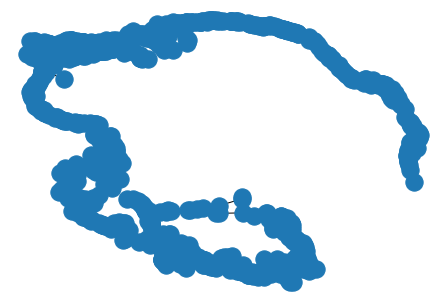

In [77]:
# Construct a MST only using the 750 points modified above
(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(points_centerline, drawMST=True, sampleNumber=5000)  

# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        toRemove = []
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")

# Displat the points on the centerline

to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)

# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

In [73]:
pointsCorInorder = []
for point in pointsInorder:
    pointsCorInorder.append(pointsCor3D_centerline[point])
np.savetxt("centerline.csv", pointsCorInorder, delimiter=" ")

In [14]:
np.savetxt("centerline6.csv", pointsCorInorder, delimiter=",")

In [5]:
displayPoints(np.load("centerlineInorder2.npy"), 1.3)

In [ ]:
c = curve()
for pointIndex in pointsInorder:
    c.append(pointCorToVector(pointsCor3D_centerline[pointIndex]))

In [66]:
toDisplay=[]
for node in graph_centerline.nodes():
    toDisplay.append(pointsCor3D_centerline[node])
displayPoints(toDisplay, 1.3)